# Realiza el Entrenamiento del Modelo para Detección de los Operadores de un Cursograma usando Ultralytics YOLO

Basado en https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models

utilizando  la librería https://docs.ultralytics.com/es/



Nota: originalmente se usaban los modelos de TF1 y TF2 pero han dejado de funcionar en Colab:

- TF1 -> https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/

- TF2 -> https://towardsdatascience.com/how-to-train-a-tensorflow-2-object-detection-model-25d4da64b817 +  https://colab.research.google.com/drive/1sLqFKVV94wm-lglFq_0kGo2ciM0kecWD#scrollTo=fF8ysCfYKgTP&uniqifier=1


# Preparación del entorno:

In [1]:
#@title Verificar disponibilidad de GPU NVIDIA
!nvidia-smi

Wed Oct  1 14:13:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#@title Instalar Ultralytics
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.9 MB/s eta 0:00:00


In [3]:
#@title Cargar Librerías
import os
import pandas as pd
import numpy as np

import xml.etree.ElementTree as ET

import yaml

from IPython.display import Image
import tempfile

import shutil

import ultralytics
ultralytics.checks()

print ("Librerías cargadas.")

Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.4/112.6 GB disk)
Librerías cargadas.


# Preparación datos:

In [4]:
#@title Montar Google Drive
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


# directorio local en Google Drive
#@markdown Carpeta principal:
path = '/content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles' #@param {type:"string"}

#@markdown Carpetas Entrenamiento & Validación:
subdir_Entrenamiento = '/train' #@param {type:"string"}
subdir_Validacion = '/validation' #@param {type:"string"}

#@markdown SubCarpetas tipo de Datos:
subdir_subdir_Imagenes = '/images' #@param ['/images' ]
##subdir_subdir_XML = '/annotations'  #param {type:"string"}
subdir_subdir_LABEL = '/labels'  #@param ['/labels' ]
#@markdown - nota:  los archivos con las Imágenes y los LABELS formato YOLO deben estar con este nombre de carpeta porque es donde lo va a buscar la librería.


subdirTrainImages = subdir_Entrenamiento + subdir_subdir_Imagenes
#subdirTrainXML = subdir_Entrenamiento + subdir_subdir_XML
subdirTrainLABELS = subdir_Entrenamiento + subdir_subdir_LABEL

subdirValImages = subdir_Validacion + subdir_subdir_Imagenes
#subdirValXML = subdir_Validacion + subdir_subdir_XML
subdirValLABELS = subdir_Validacion + subdir_subdir_LABEL
print("\n")

def fmtContarArchios(dir, extList=None):
  res = contarArchivos(dir, extList)
  if res < 0:
    return "NO EXISTE!"
  else:
    return str(res)

def contarArchivos(dir, extList=None):
  if not os.path.isdir(dir):
    return -1
  all = os.listdir(dir)
  if (extList is None) or (len(extList)==0):
    return len(all)
  else:
    count = 0
    for fn in all:
      _, ext = os.path.splitext(fn)
      if ext.lower() in extList:
        count = count + 1
    return count


print("\n Para Entrenamiento: ")
print("\t Imágenes: ", fmtContarArchios(path+subdirTrainImages))
print("\t LABELs: ", fmtContarArchios(path+subdirTrainLABELS))

print("\n Para Validación: ")
print("\t Imágenes: ",fmtContarArchios(path+subdirValImages))
print("\t LABELs: ",fmtContarArchios(path+subdirValLABELS))

print("")


Mounted at /content/gdrive



 Para Entrenamiento: 
	 Imágenes:  850
	 LABELs:  850

 Para Validación: 
	 Imágenes:  50
	 LABELs:  50



In [5]:
#@title Definir clases a entrenar

archivo_clases = "classes.txt" #@param {type:"string"}

def load_classes(classes_txt_path):
  if not os.path.isfile(classes_txt_path):
    print("\t ERROR: no se encuentra el archivo ", classes_txt_path, " disponible!")
    return []
  with open(classes_txt_path, 'r') as f:
    class_list = {}
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      data = line.split(":")
      class_list[int(data[0].strip())] = str(data[1].strip())
    return class_list


# define nombre archivo clases
classes_map_fname = path + '/classes.txt'
classes_map = None

# utiliza archivo existente
print("\n-- cargando archivo de clases: ", classes_map_fname)
classes_map = load_classes(classes_map_fname)

# muestra clases cargadas
if classes_map is not None:
  print("\n> clases cargadas [" + str(len(classes_map)) + "]: ")
  for clId in classes_map.keys():
    print("\t id ", clId, " -> clase", classes_map[clId])



-- cargando archivo de clases:  /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles/classes.txt

> clases cargadas [10]: 
	 id  0  -> clase 2
	 id  1  -> clase 0
	 id  2  -> clase 8
	 id  3  -> clase 6
	 id  4  -> clase 4
	 id  5  -> clase 3
	 id  6  -> clase 1
	 id  7  -> clase 7
	 id  8  -> clase 9
	 id  9  -> clase 5


# Creación del Modelo:

In [6]:
#@title Crear archivo de configuración data.yaml

def create_data_yaml(drive_path, train_subpath, val_subpath, clases_list, path_to_data_yaml):

  # Create data dictionary
  data = {
      'path': drive_path,
      'train': drive_path+train_subpath, # para labels se toma este path y se cambia "images" por "labels"
      'val': drive_path+val_subpath, # para labels se toma este path y se cambia "images" por "labels"
      'nc': len(clases_list),
      'names': clases_list
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print("-> Archivo de configuración creado en ", path_to_data_yaml)

  return

# Define path to classes.txt and run function
path_to_data_yaml = '/content/YOLOconfig.yaml'

create_data_yaml(path, subdirTrainImages, subdirValImages, classes_map, path_to_data_yaml)

# muestra datos del archivo
print("")
!cat {path_to_data_yaml}

-> Archivo de configuración creado en  /content/YOLOconfig.yaml

path: /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles
train: /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles/train/images
val: /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles/validation/images
nc: 10
names:
  0: '2'
  1: '0'
  2: '8'
  3: '6'
  4: '4'
  5: '3'
  6: '1'
  7: '7'
  8: '9'
  9: '5'


In [7]:
#@title Entrenar el Modelo

epochs=25 #@param{type:"integer"}
imgsz="480" #@param [320, 480, 640]
preTrained_model_name = "yolo11n.pt" #@param["yolo11n.pt"]

epochs = max(epochs, 1)

#  load a pretrained model (recommended for training)
model = ultralytics.YOLO(preTrained_model_name)

# Train the model
results = model.train(data=path_to_data_yaml,
                      epochs=epochs,
                      imgsz=int(imgsz))


Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/YOLOconfig.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=480, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

# Evaluación del Modelo:

Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.7±0.2 ms, read: 26.3±4.2 MB/s, size: 44.5 KB)
val: Scanning /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles/validation/labels.cache... 50 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 50/50 95.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.6it/s 2.5s
                   all         50        750      0.993      0.982      0.994       0.92
                     2         44         95          1      0.954      0.994      0.923
                     0         35         60      0.997          1      0.995      0.944
                     8         45         96          1      0.937      0.993      0.926
                     6         39         74      0.999      0.973      0.995      0.927
      

shape: (10, 8)
┌───────┬────────┬───────────┬─────────┬─────────┬─────────┬─────────┬──────────┐
│ Class ┆ Images ┆ Instances ┆ Box-P   ┆ Box-R   ┆ Box-F1  ┆ mAP50   ┆ mAP50-95 │
│ ---   ┆ ---    ┆ ---       ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ ---      │
│ str   ┆ i64    ┆ i64       ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆ f64      │
╞═══════╪════════╪═══════════╪═════════╪═════════╪═════════╪═════════╪══════════╡
│ 2     ┆ 44     ┆ 95        ┆ 1.0     ┆ 0.95432 ┆ 0.97663 ┆ 0.99427 ┆ 0.92281  │
│ 0     ┆ 35     ┆ 60        ┆ 0.99723 ┆ 1.0     ┆ 0.99862 ┆ 0.995   ┆ 0.94438  │
│ 8     ┆ 45     ┆ 96        ┆ 1.0     ┆ 0.93745 ┆ 0.96772 ┆ 0.99299 ┆ 0.92588  │
│ 6     ┆ 39     ┆ 74        ┆ 0.99906 ┆ 0.97297 ┆ 0.98585 ┆ 0.99473 ┆ 0.9274   │
│ 4     ┆ 36     ┆ 61        ┆ 0.9833  ┆ 0.96538 ┆ 0.97426 ┆ 0.98959 ┆ 0.92067  │
│ 3     ┆ 41     ┆ 83        ┆ 0.99003 ┆ 1.0     ┆ 0.99499 ┆ 0.995   ┆ 0.93003  │
│ 1     ┆ 32     ┆ 62        ┆ 0.99288 ┆ 1.0     ┆ 0.99643 ┆ 0.995   ┆ 0.93119  │
│ 7     ┆ 36     ┆ 70        ┆ 0.99844 ┆ 1.0     ┆ 0.99922 ┆ 0.995   ┆ 0.91966  │
│ 9     ┆ 38     ┆ 67        ┆ 0.9868  ┆ 0.98507 ┆ 0.98594 ┆ 0.99444 ┆ 0.88624  │
│ 5     ┆ 43     ┆ 82        ┆ 0.98649 ┆ 1.0     ┆ 0.9932  ┆ 0.99488 ┆ 0.8881   │
└───────┴────────┴───────────┴─────────┴─────────┴─────────┴─────────┴──────────┘


> Matriz de confusión: 


shape: (11, 12)
┌────────────┬──────┬──────┬──────┬───┬──────┬──────┬──────┬────────────┐
│ Predicted  ┆ 2    ┆ 0    ┆ 8    ┆ … ┆ 7    ┆ 9    ┆ 5    ┆ background │
│ ---        ┆ ---  ┆ ---  ┆ ---  ┆   ┆ ---  ┆ ---  ┆ ---  ┆ ---        │
│ str        ┆ f64  ┆ f64  ┆ f64  ┆   ┆ f64  ┆ f64  ┆ f64  ┆ f64        │
╞════════════╪══════╪══════╪══════╪═══╪══════╪══════╪══════╪════════════╡
│ 2          ┆ 91.0 ┆ 0.0  ┆ 0.0  ┆ … ┆ 0.0  ┆ 0.0  ┆ 0.0  ┆ 0.0        │
│ 0          ┆ 0.0  ┆ 60.0 ┆ 0.0  ┆ … ┆ 0.0  ┆ 0.0  ┆ 0.0  ┆ 0.0        │
│ 8          ┆ 0.0  ┆ 0.0  ┆ 93.0 ┆ … ┆ 0.0  ┆ 1.0  ┆ 0.0  ┆ 1.0        │
│ 6          ┆ 0.0  ┆ 0.0  ┆ 0.0  ┆ … ┆ 0.0  ┆ 0.0  ┆ 0.0  ┆ 1.0        │
│ 4          ┆ 1.0  ┆ 0.0  ┆ 0.0  ┆ … ┆ 0.0  ┆ 0.0  ┆ 0.0  ┆ 0.0        │
│ …          ┆ …    ┆ …    ┆ …    ┆ … ┆ …    ┆ …    ┆ …    ┆ …          │
│ 1          ┆ 0.0  ┆ 0.0  ┆ 0.0  ┆ … ┆ 0.0  ┆ 0.0  ┆ 0.0  ┆ 0.0        │
│ 7          ┆ 0.0  ┆ 0.0  ┆ 0.0  ┆ … ┆ 70.0 ┆ 0.0  ┆ 0.0  ┆ 0.0        │
│ 9          ┆ 0.0  ┆ 0.0  ┆ 0.0  ┆ … ┆ 0.0  ┆ 66.0 ┆ 0.0  ┆ 1.0        │
│ 5          ┆ 1.0  ┆ 0.0  ┆ 1.0  ┆ … ┆ 0.0  ┆ 0.0  ┆ 81.0 ┆ 2.0        │
│ background ┆ 2.0  ┆ 0.0  ┆ 2.0  ┆ … ┆ 0.0  ┆ 0.0  ┆ 0.0  ┆ 0.0        │
└────────────┴──────┴──────┴──────┴───┴──────┴──────┴──────┴────────────┘


> mAP 50-95:  91.96359520253807

> Grafico  BoxF1_curve.png :


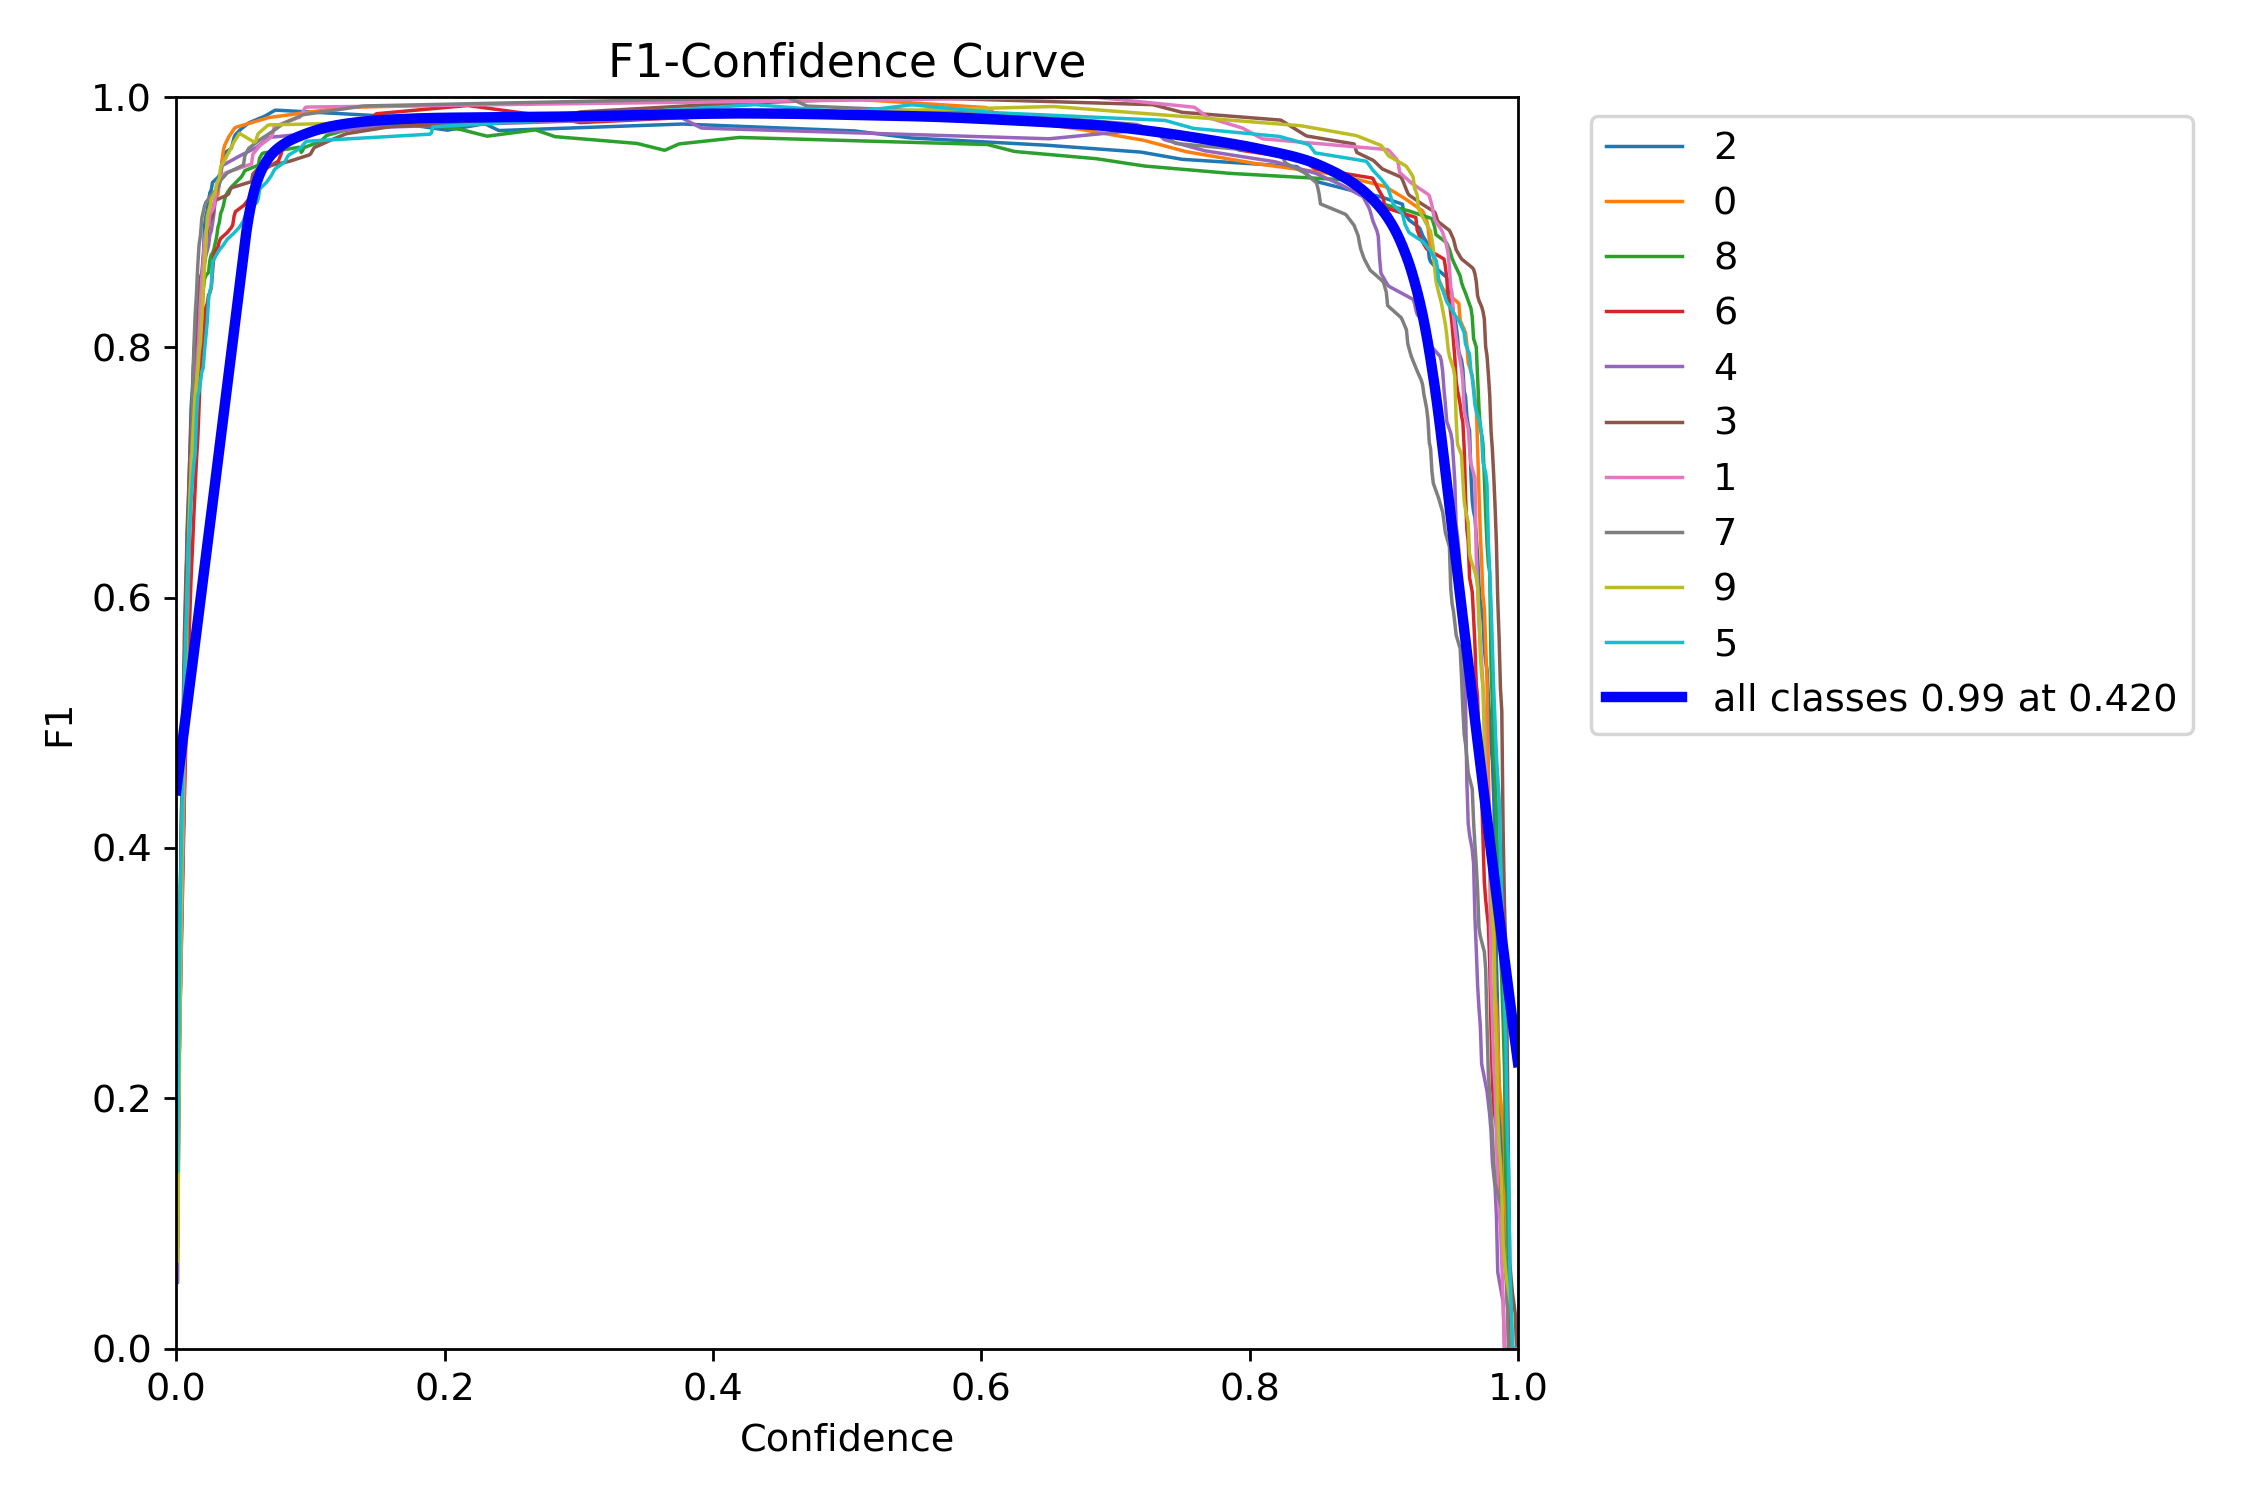


> Grafico  BoxPR_curve.png :


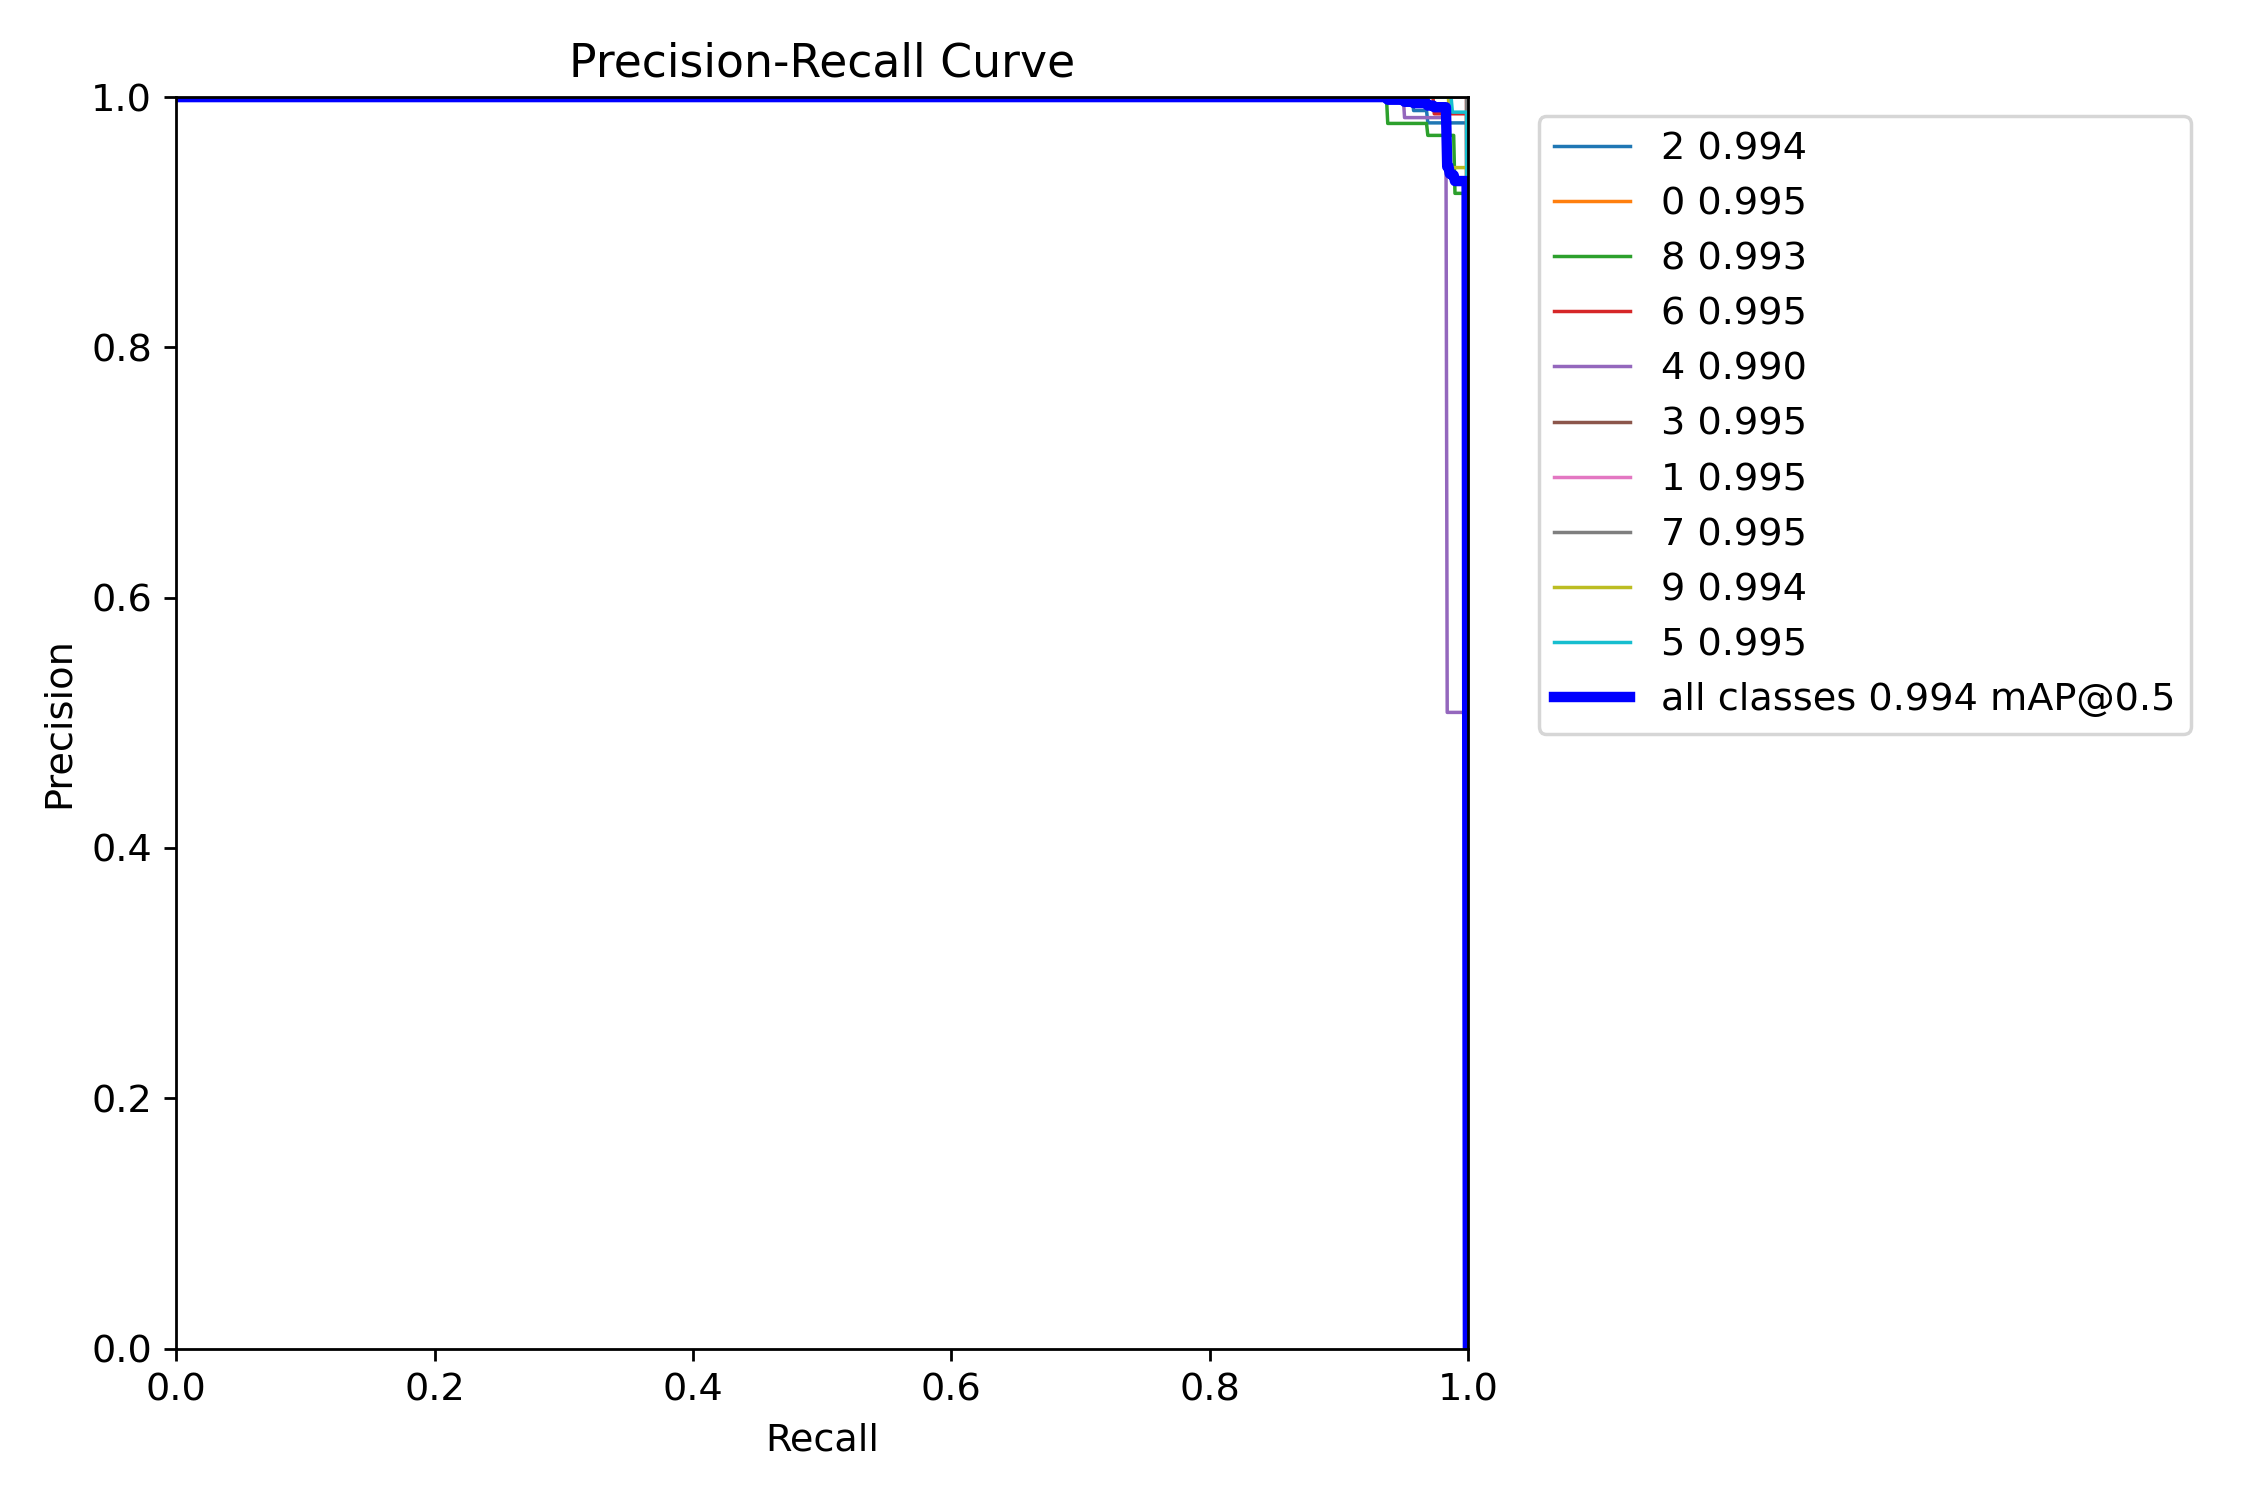


> Grafico  BoxP_curve.png :


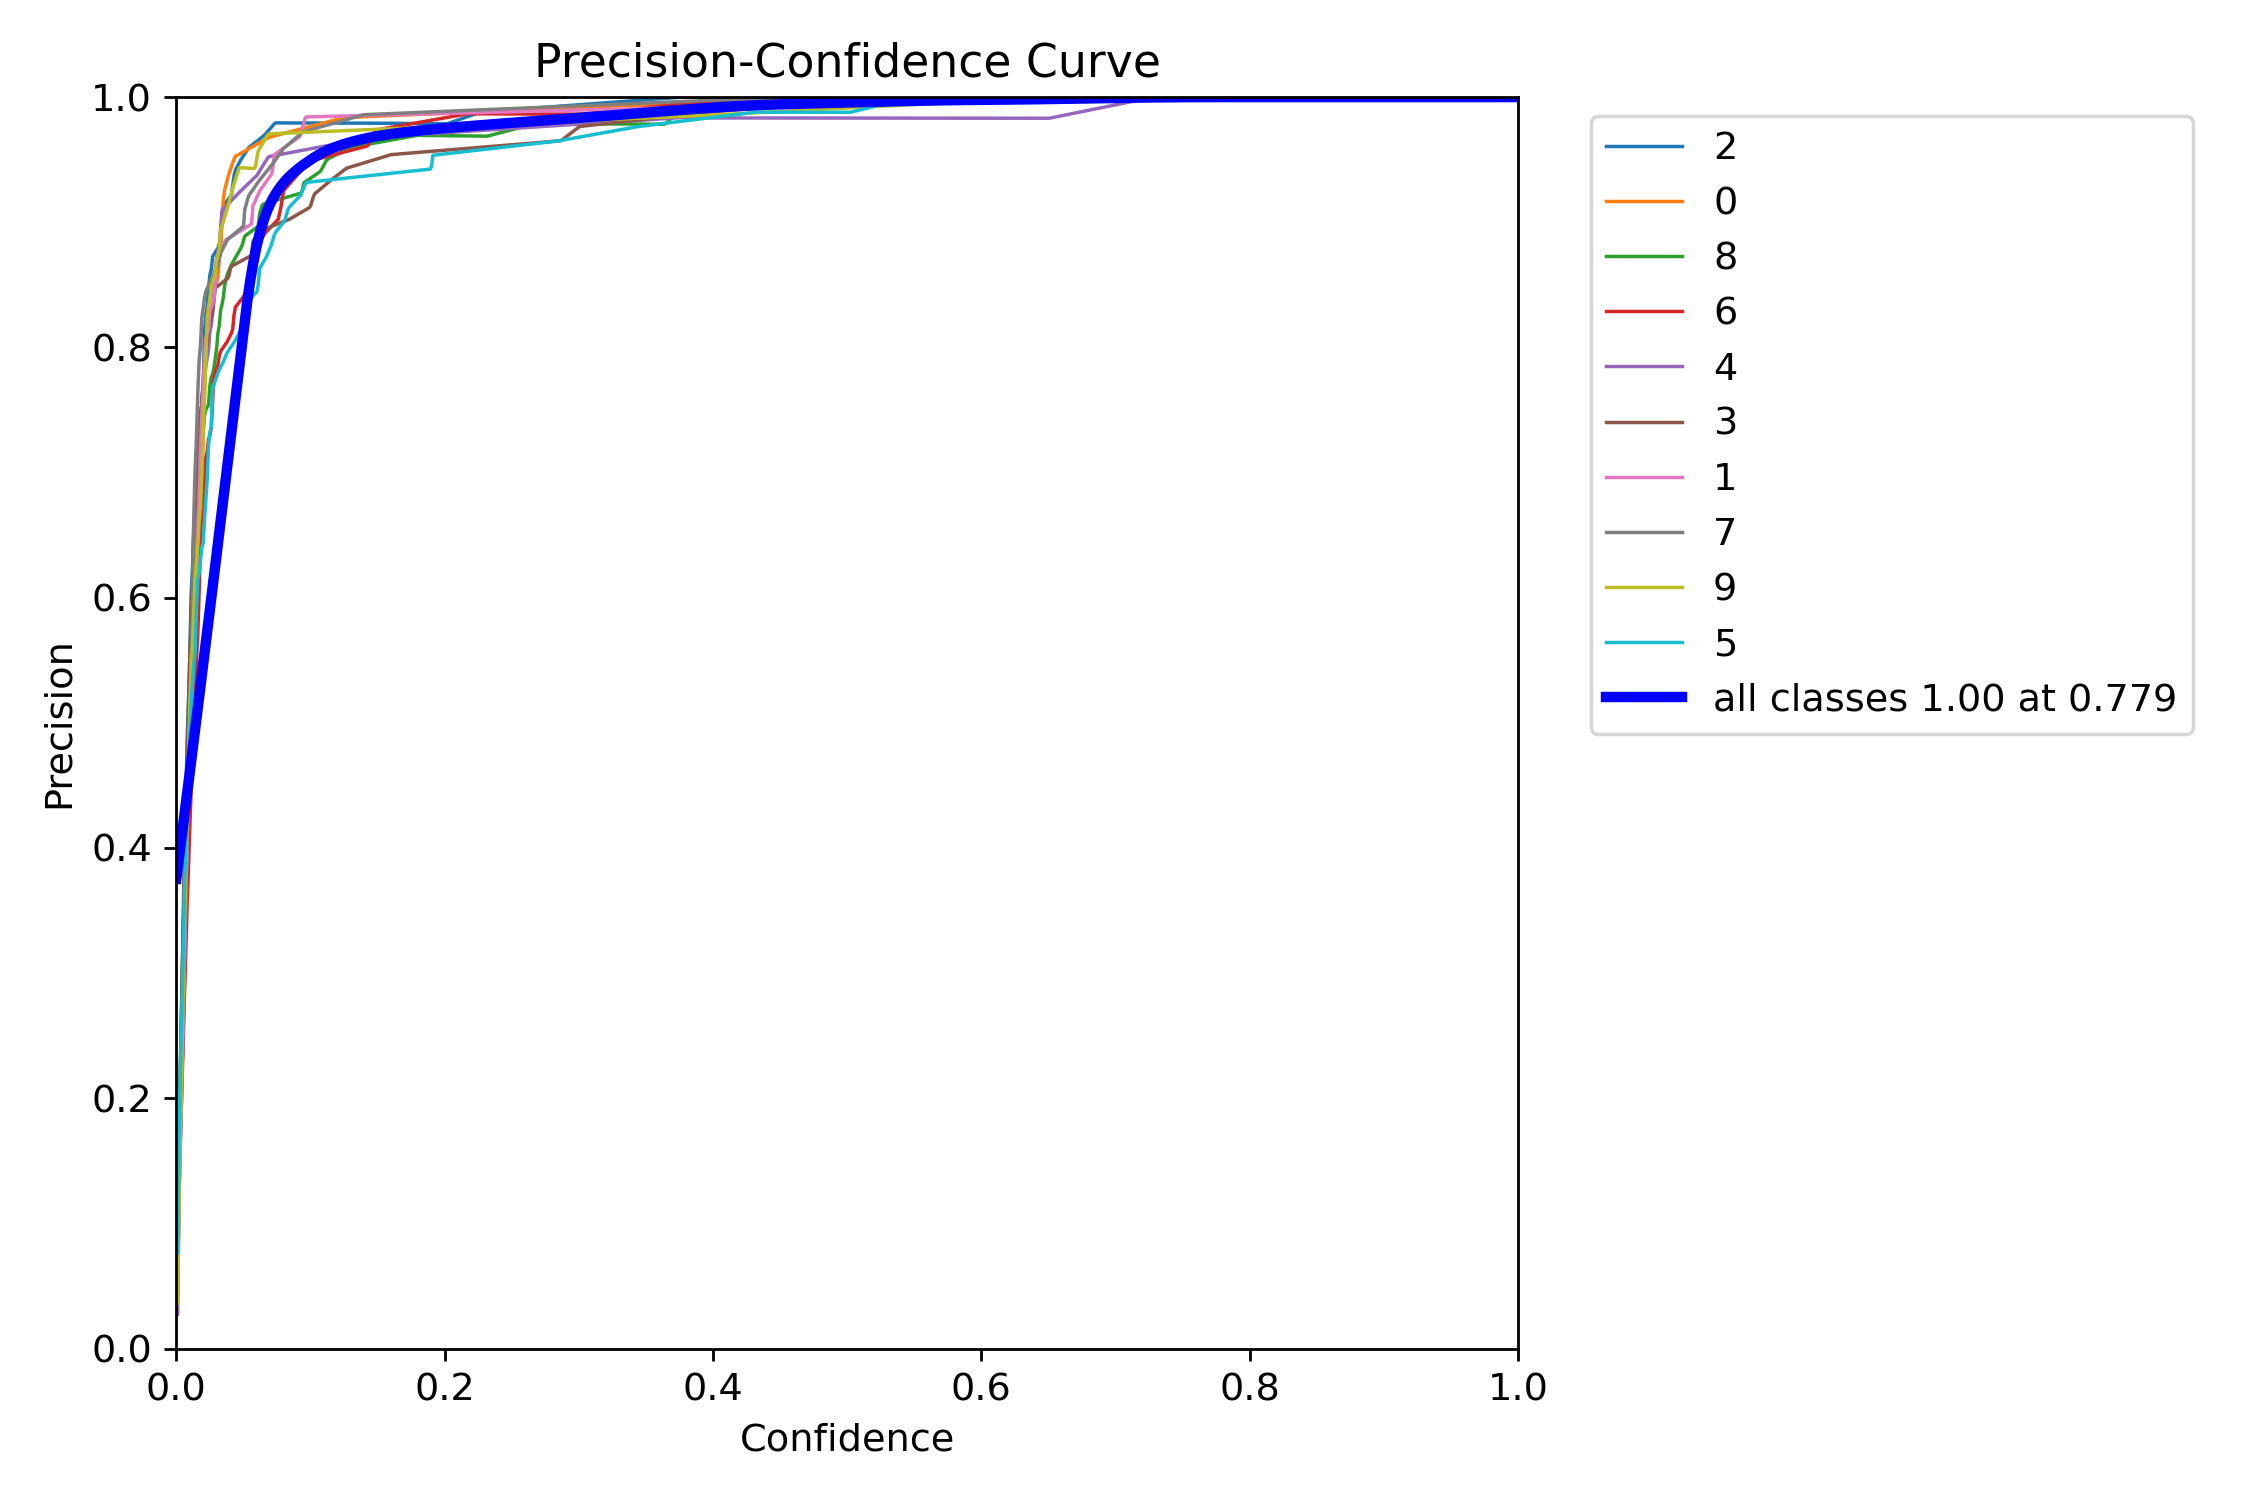


> Grafico  BoxR_curve.png :


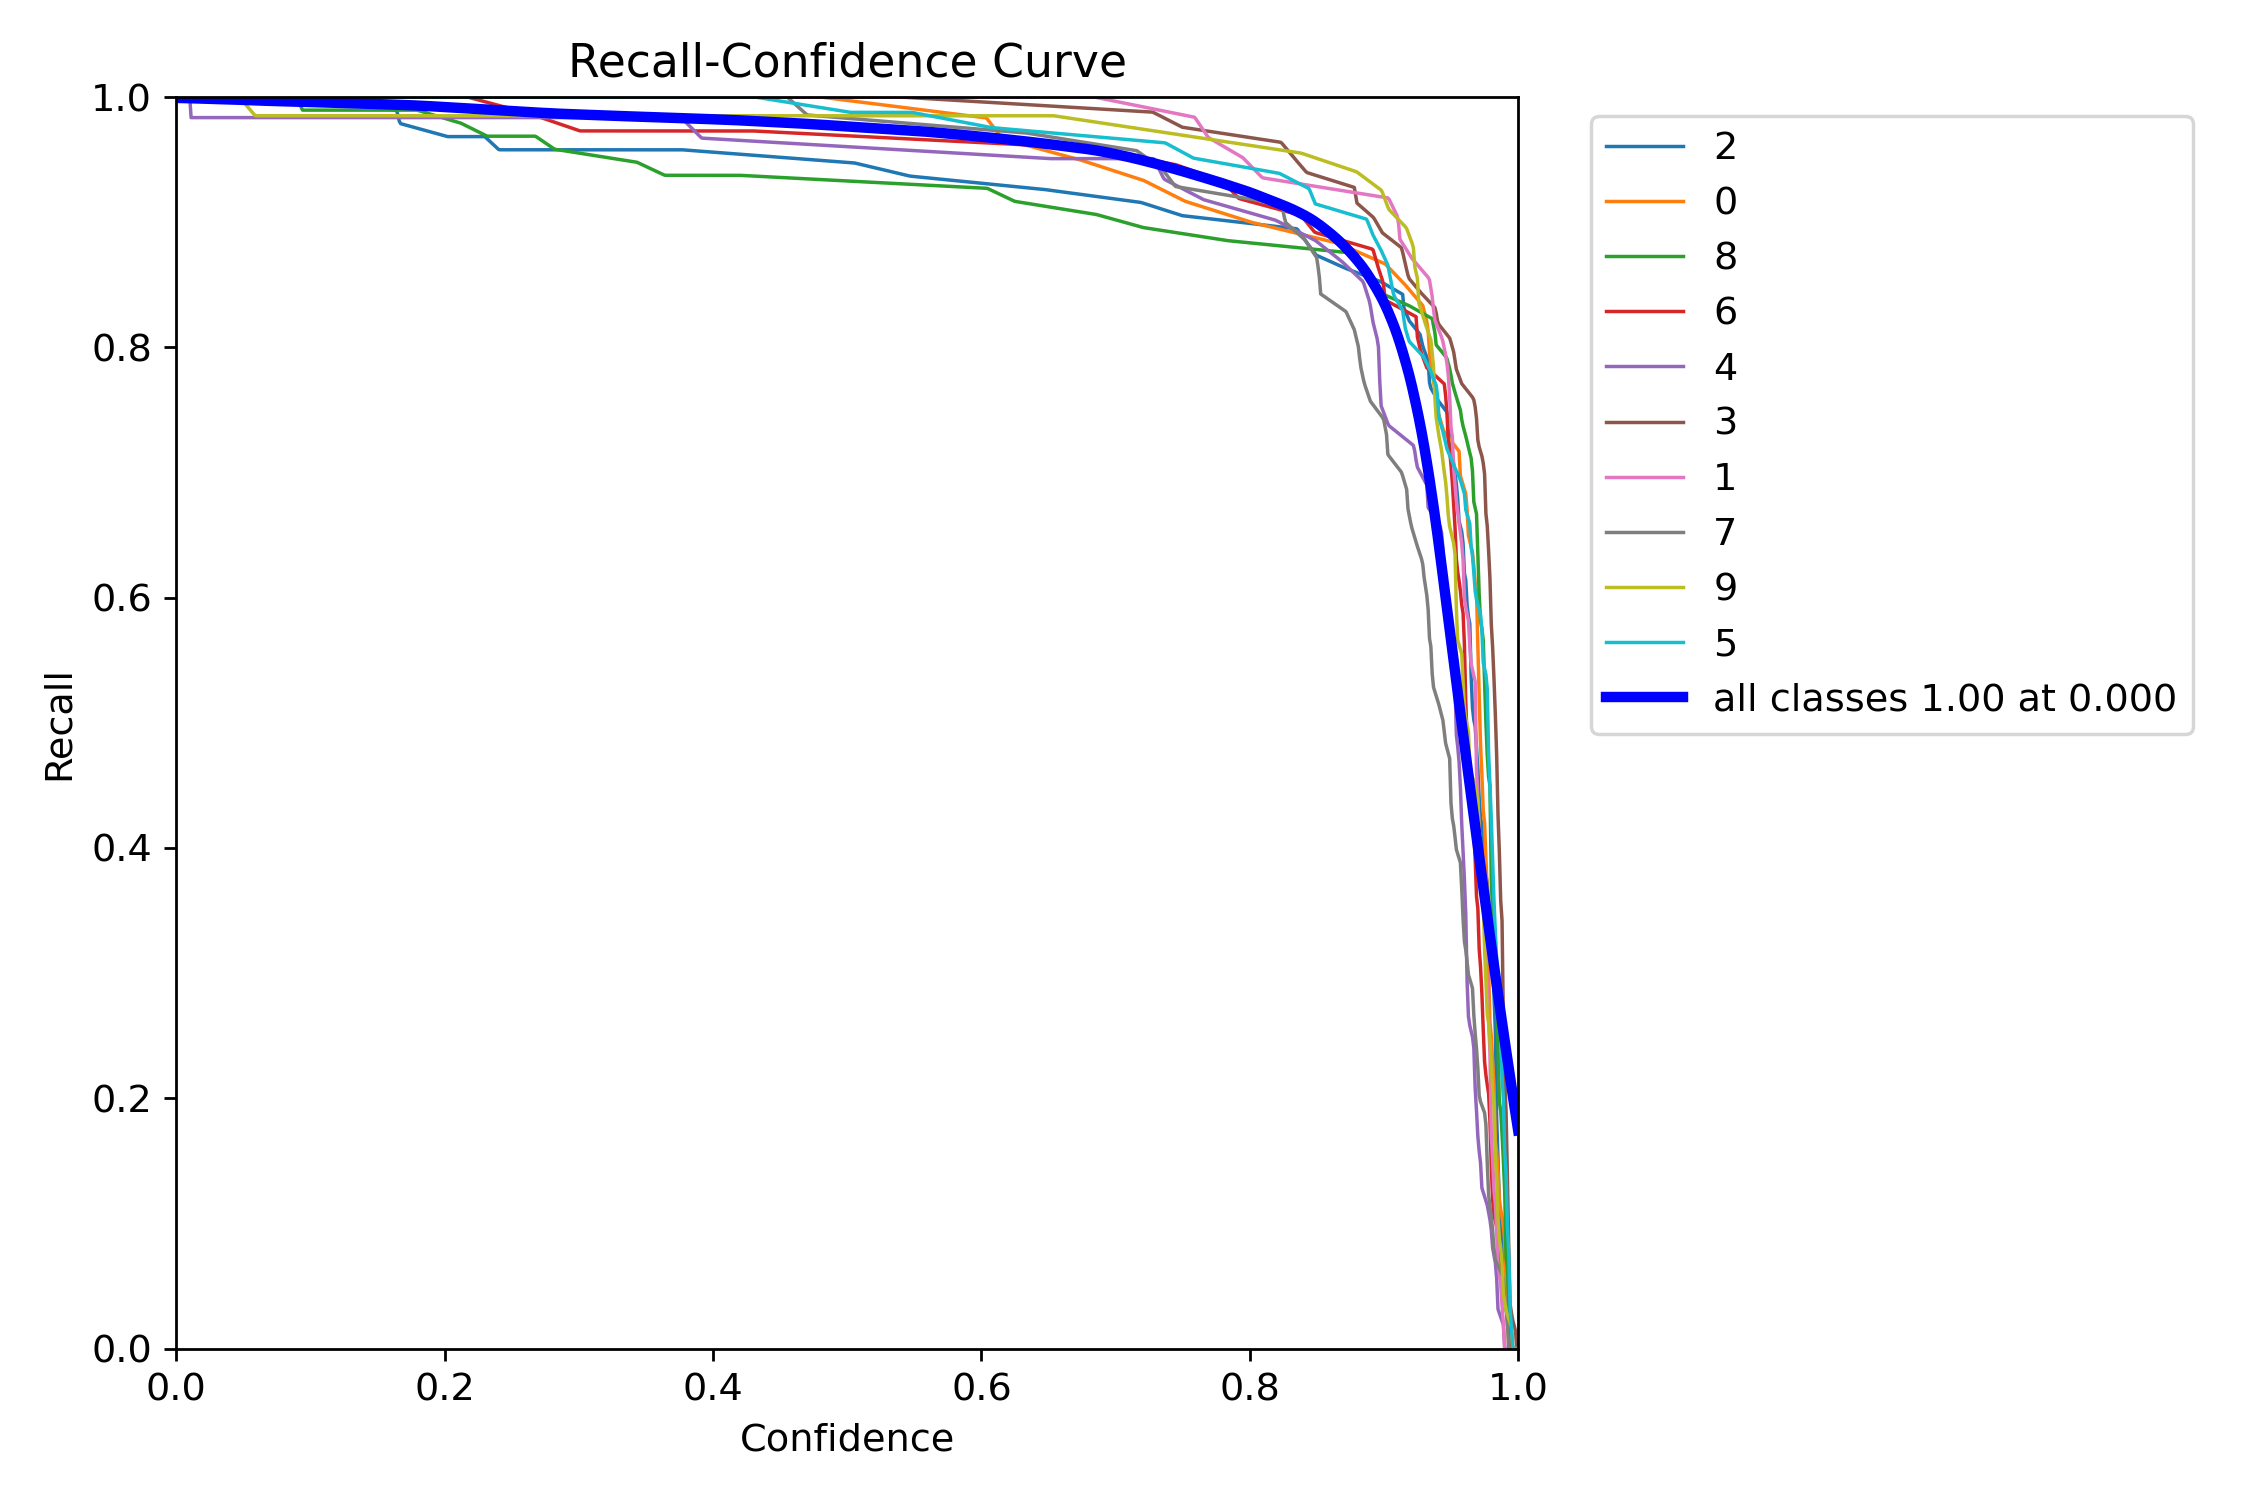


> Grafico  confusion_matrix.png :


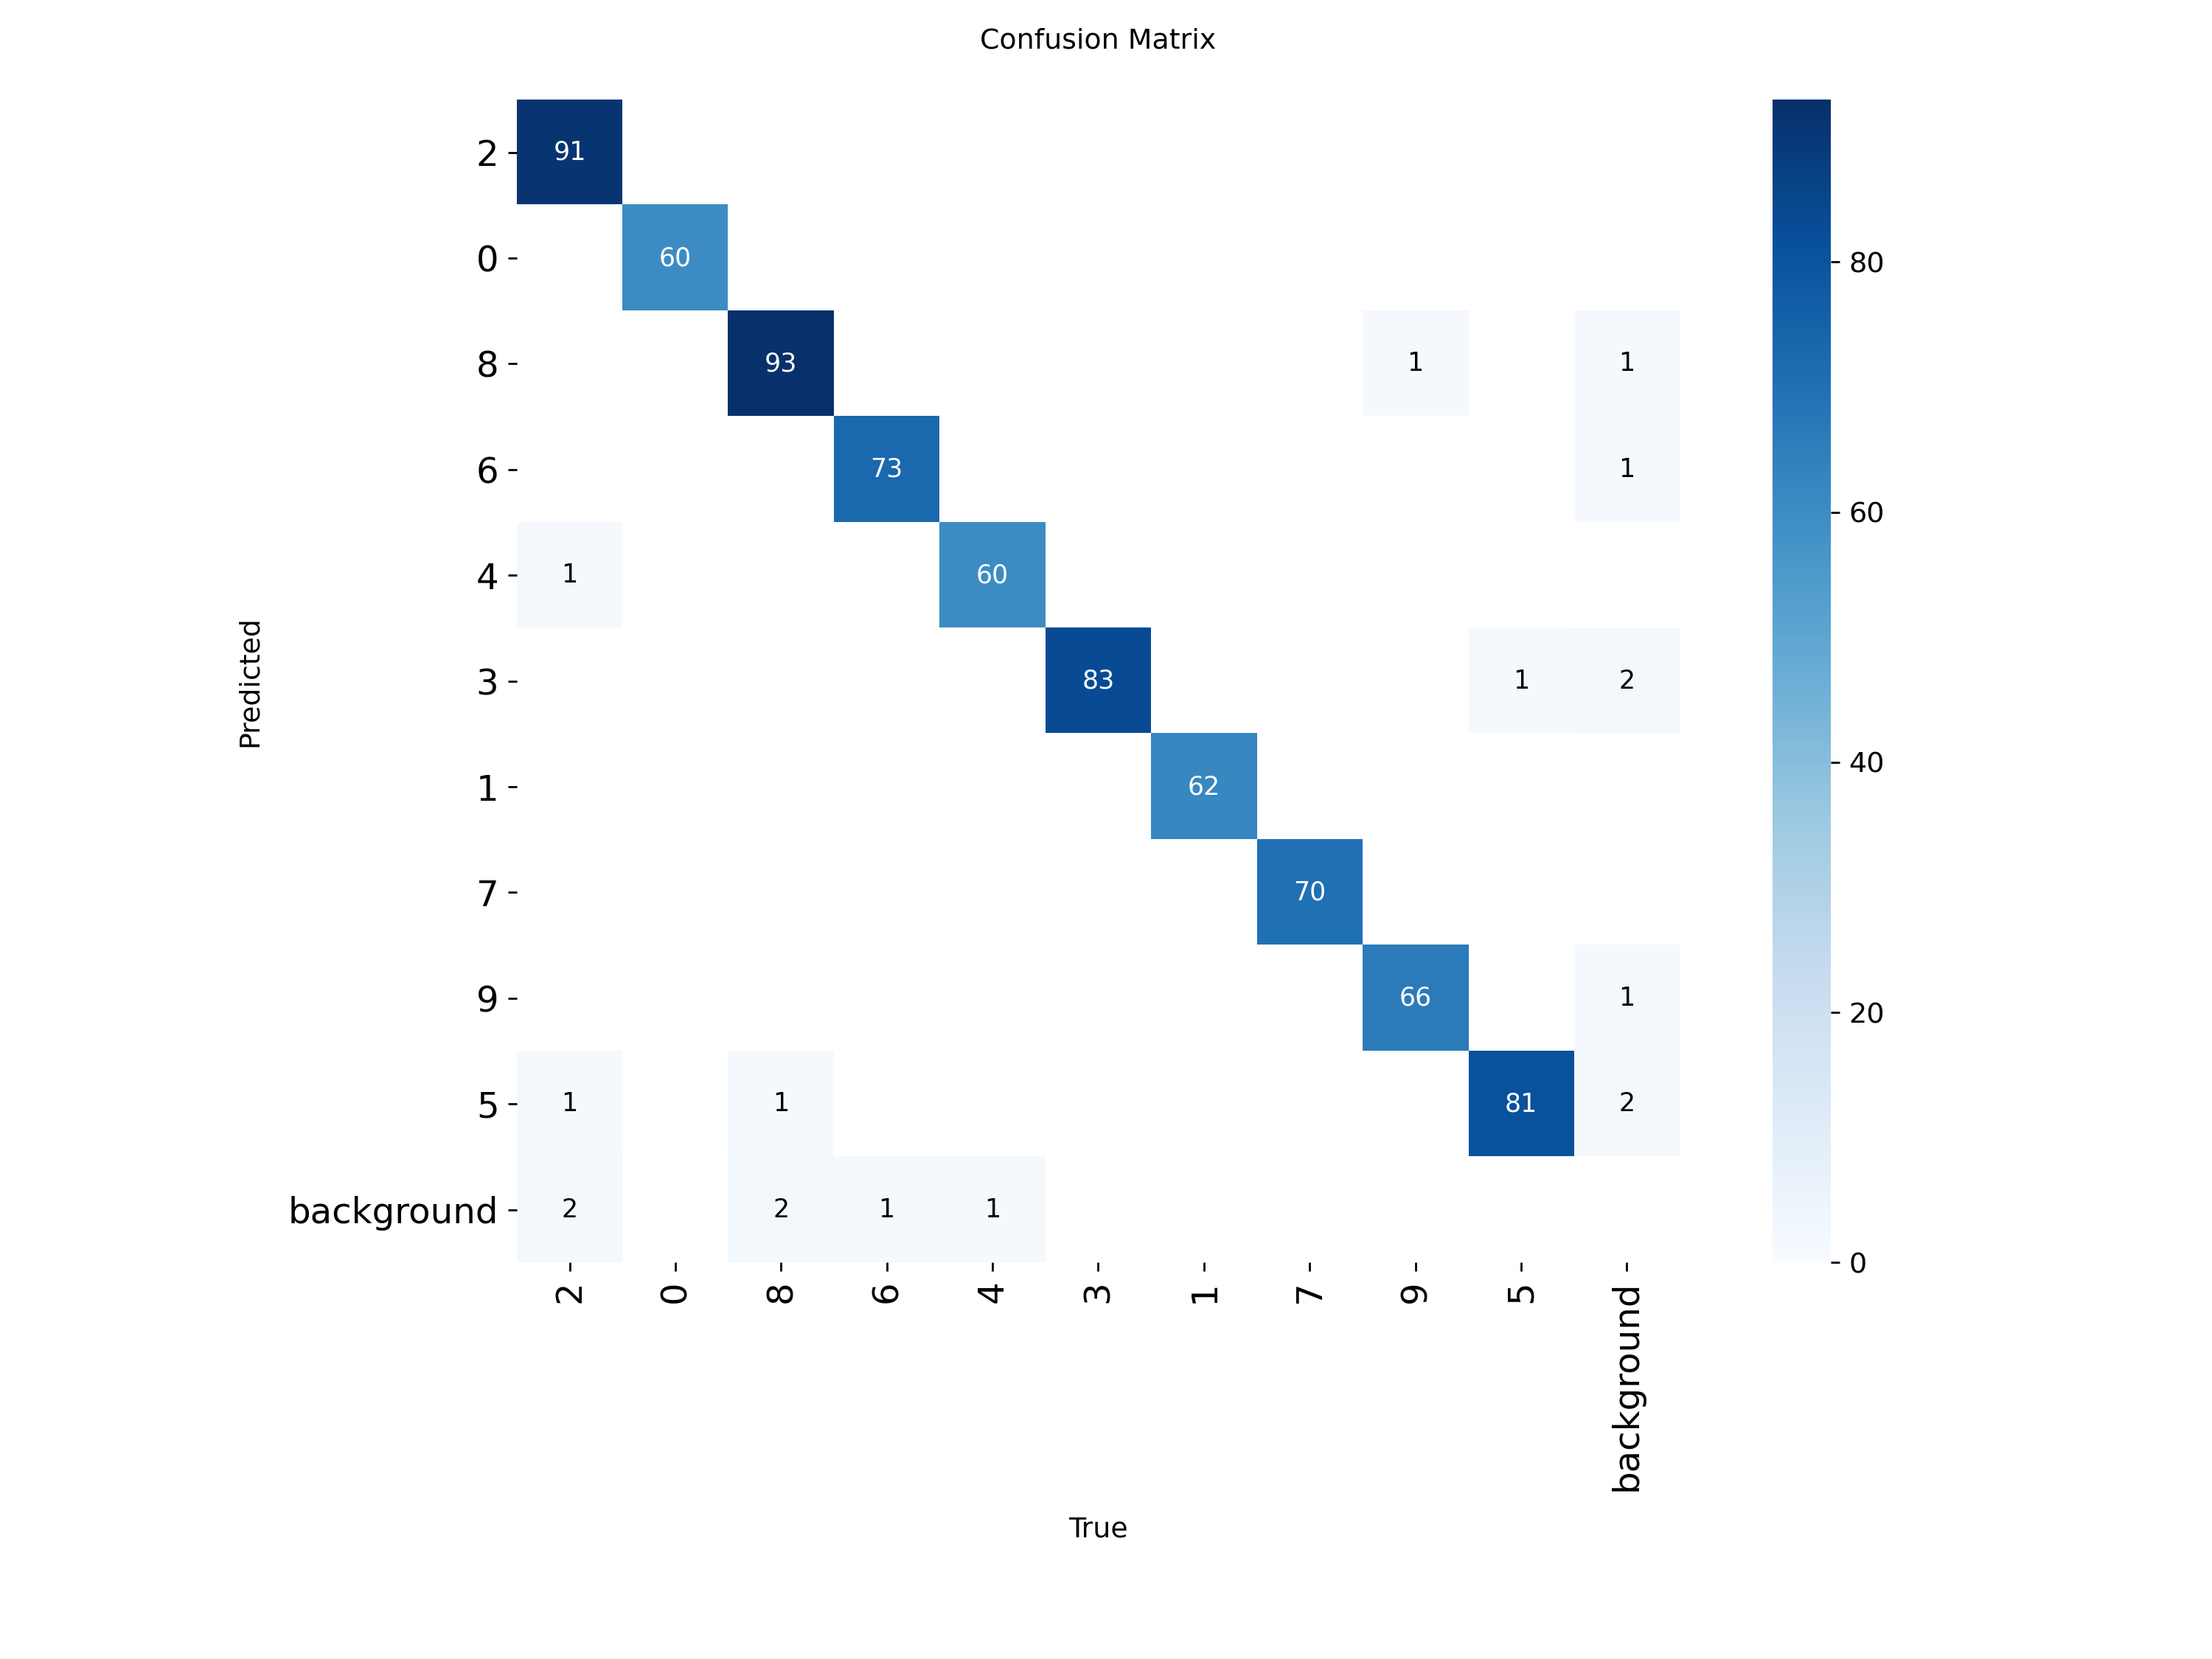


> Grafico  confusion_matrix_normalized.png :


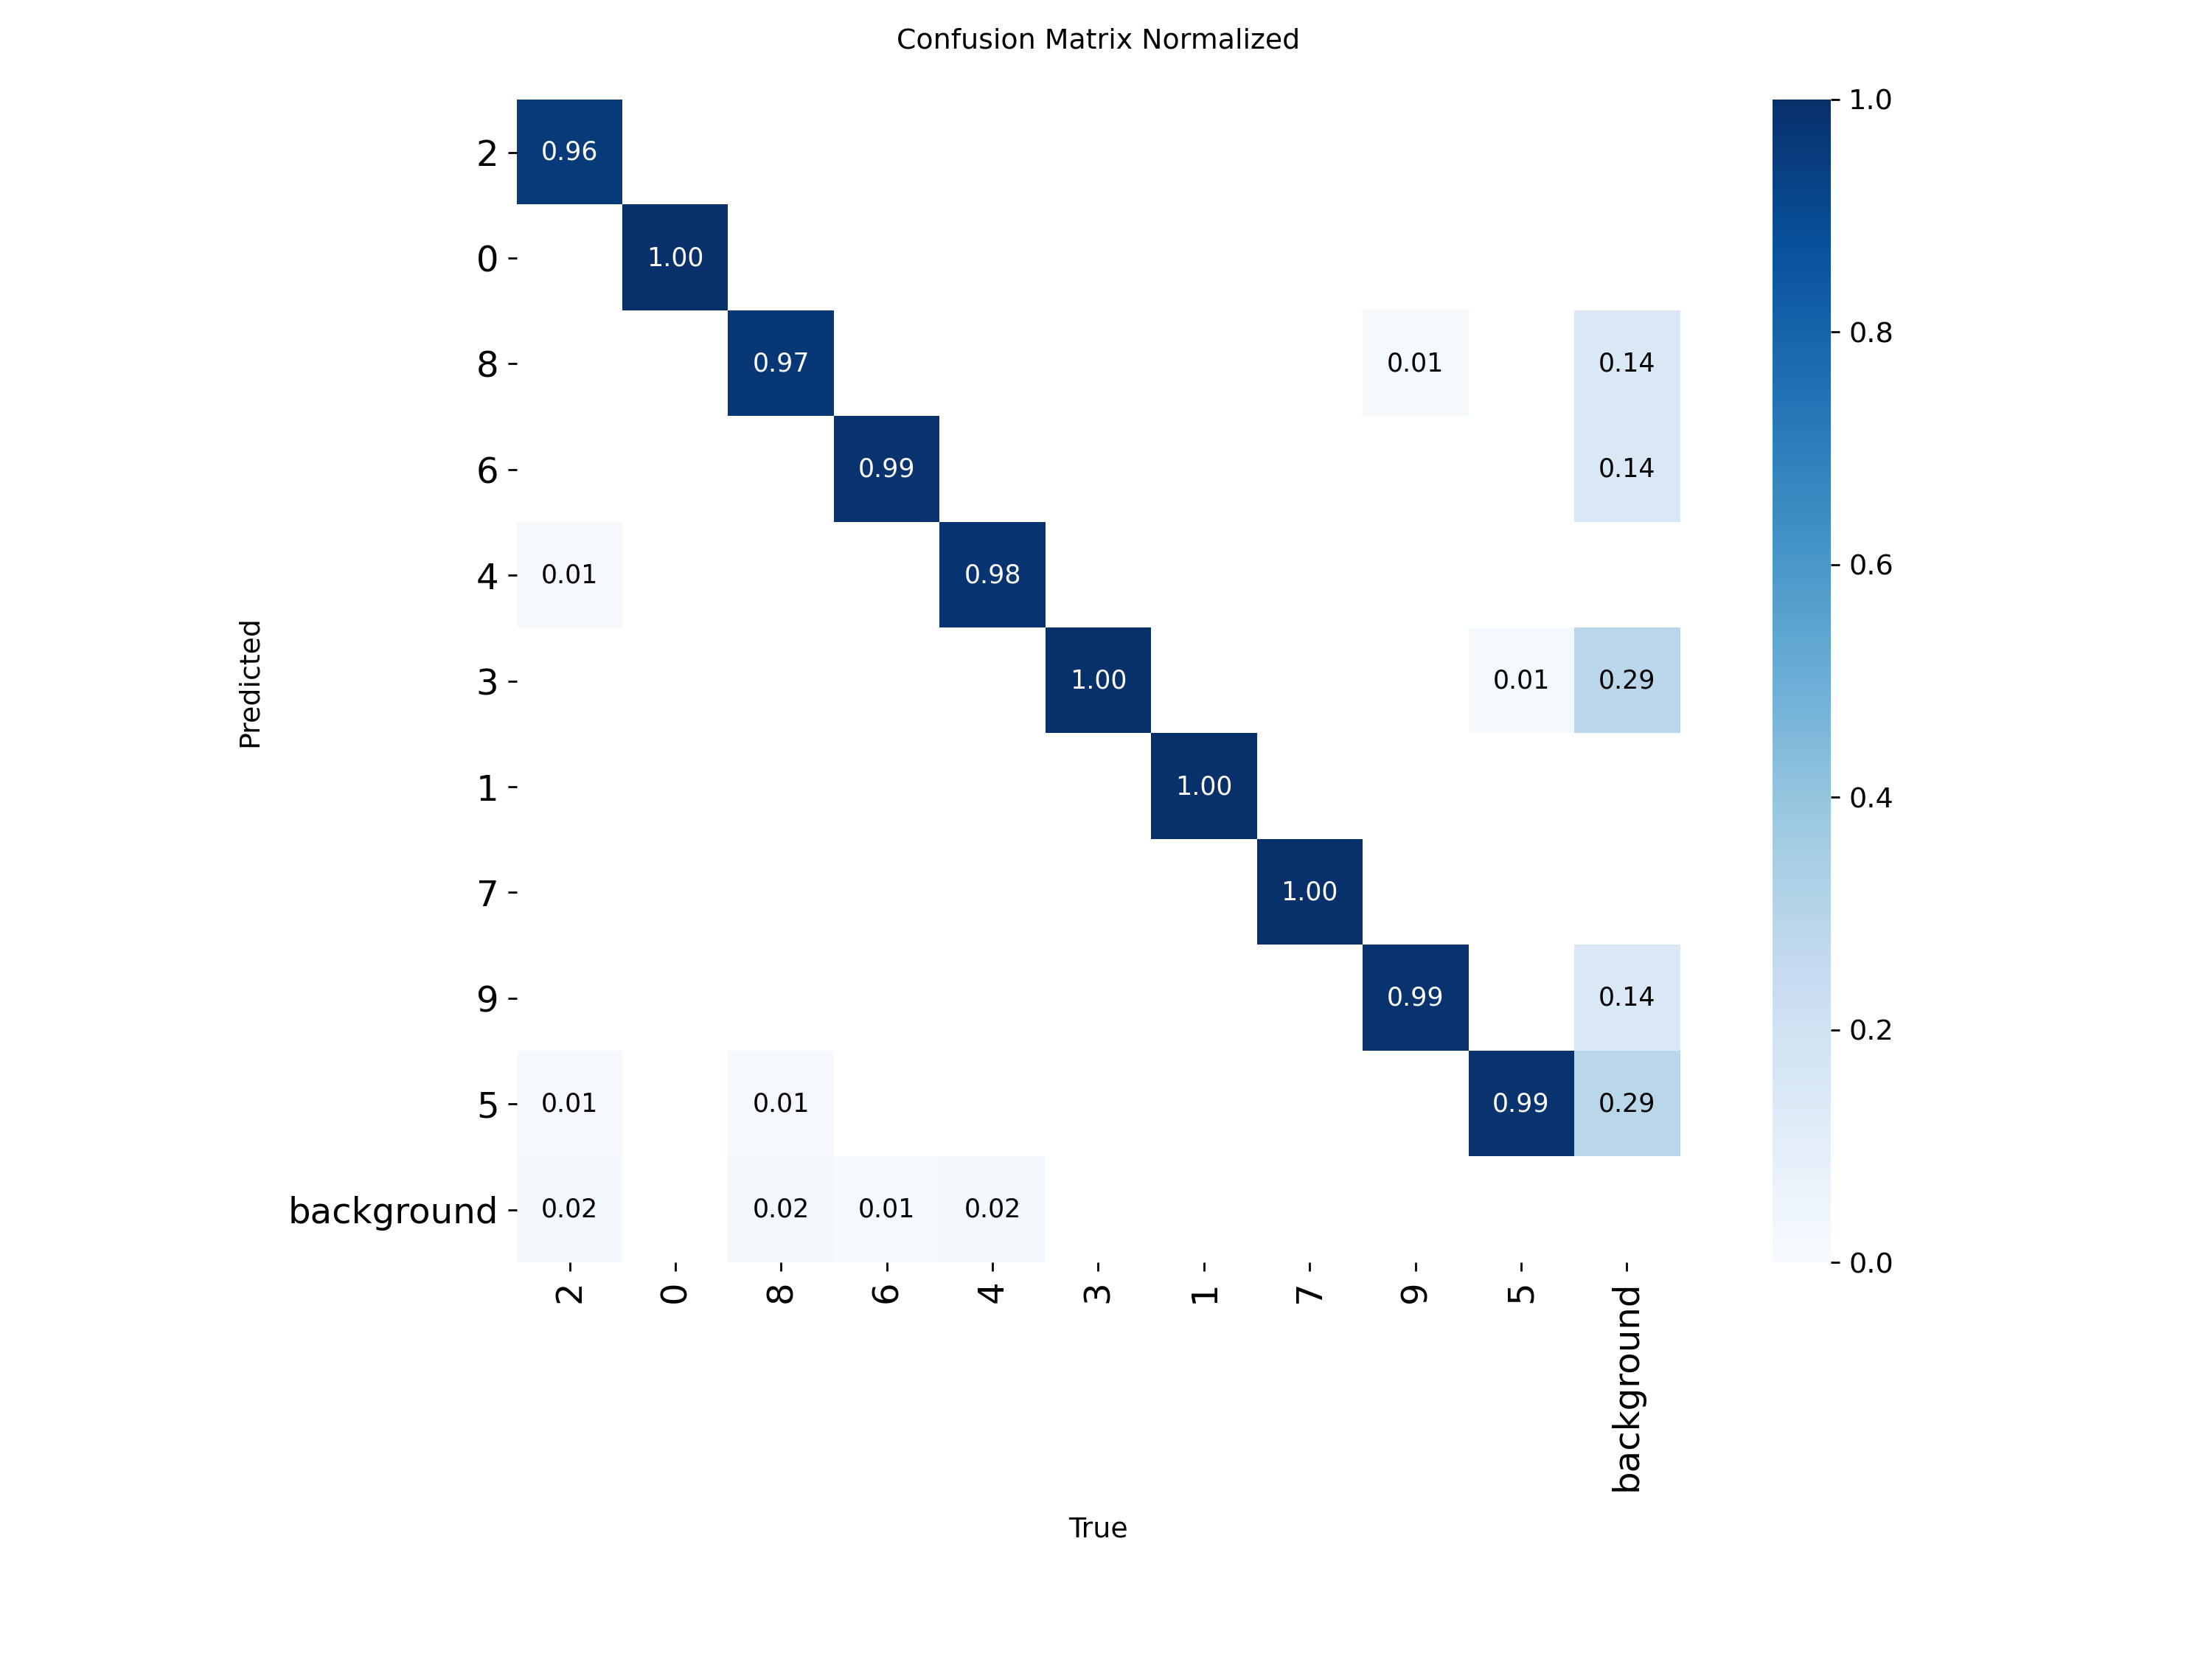


> Grafico  val_batch0_labels.jpg :


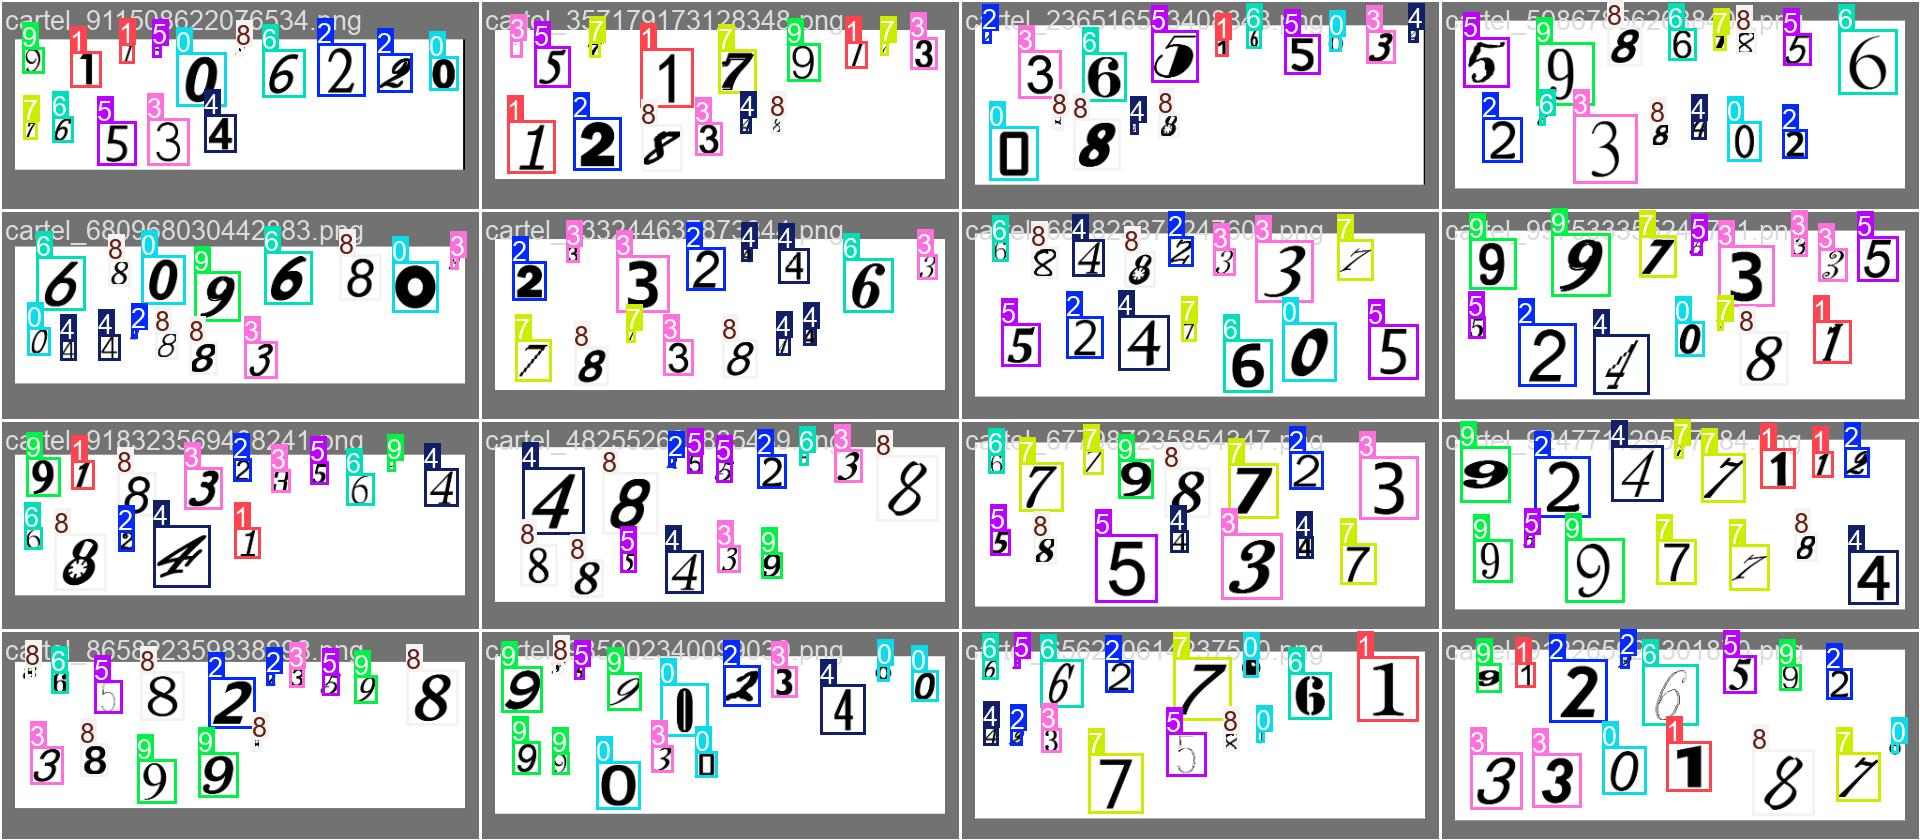


> Grafico  val_batch0_pred.jpg :


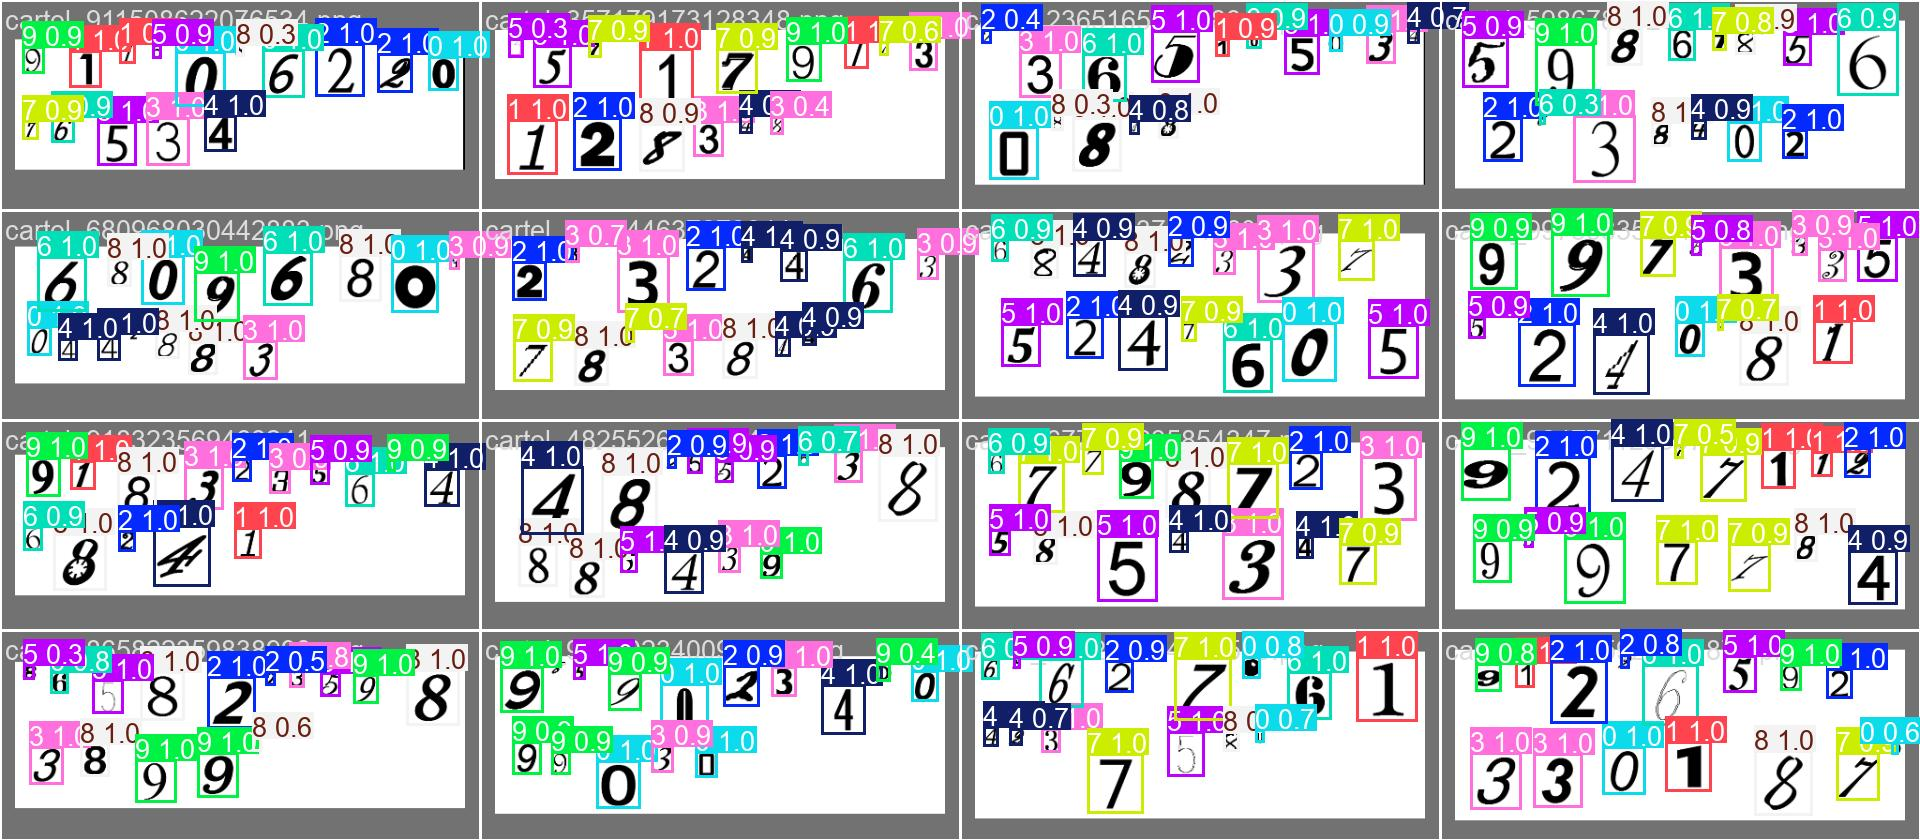


> Grafico  val_batch1_labels.jpg :


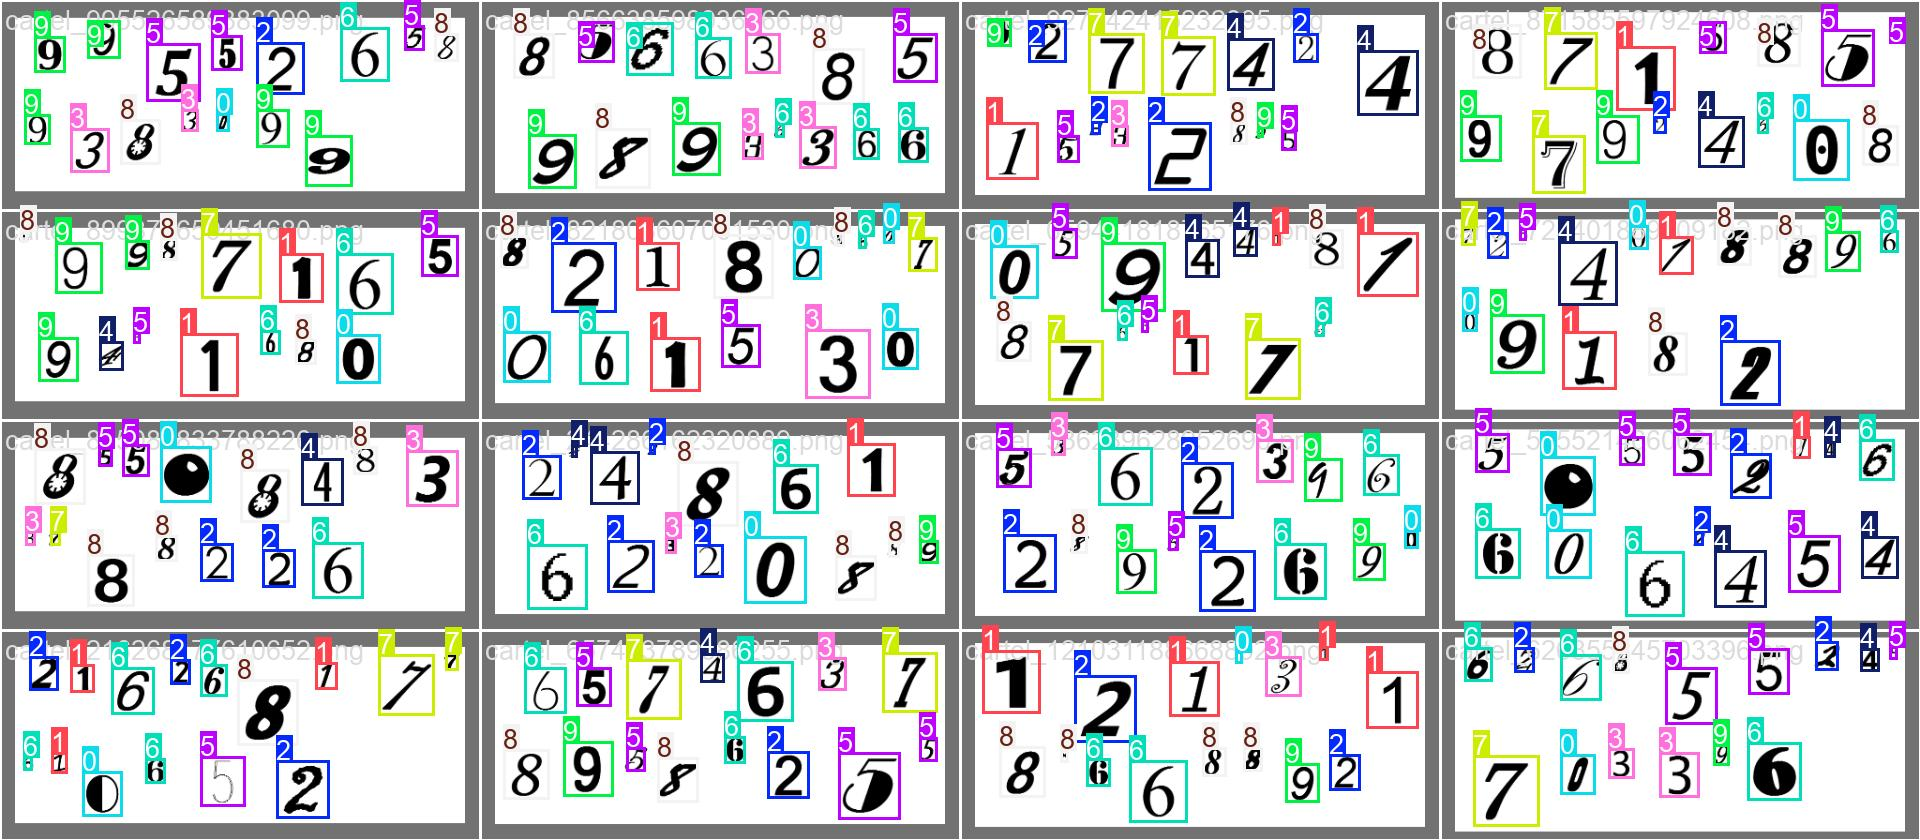


> Grafico  val_batch1_pred.jpg :


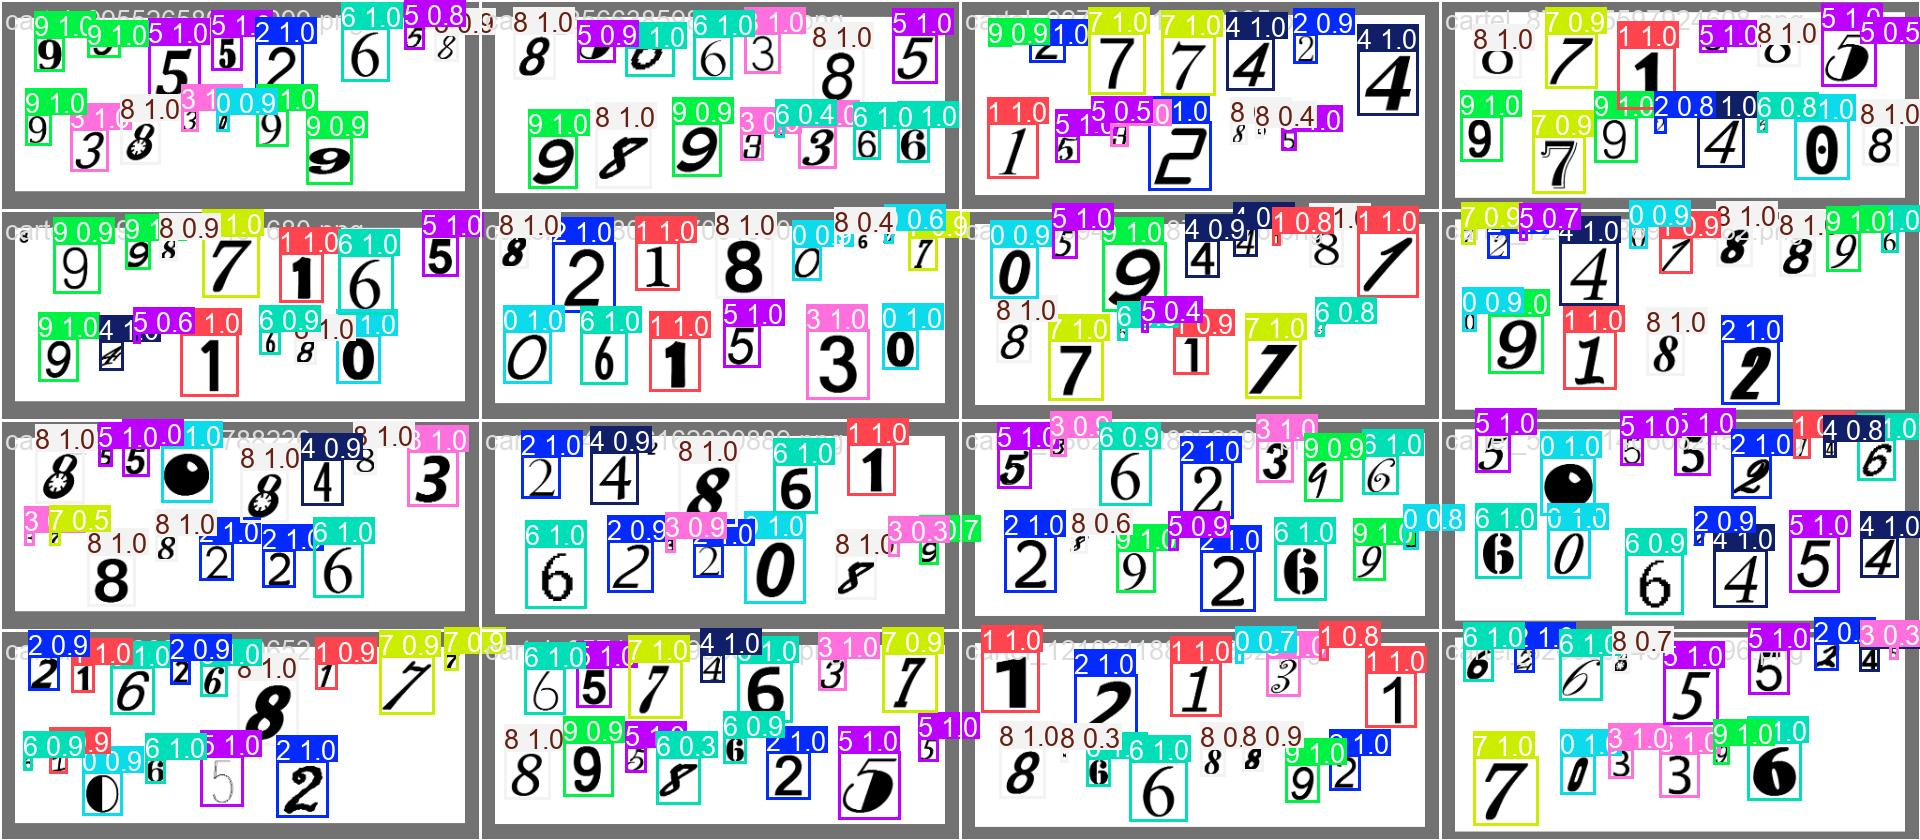


> Grafico  val_batch2_labels.jpg :


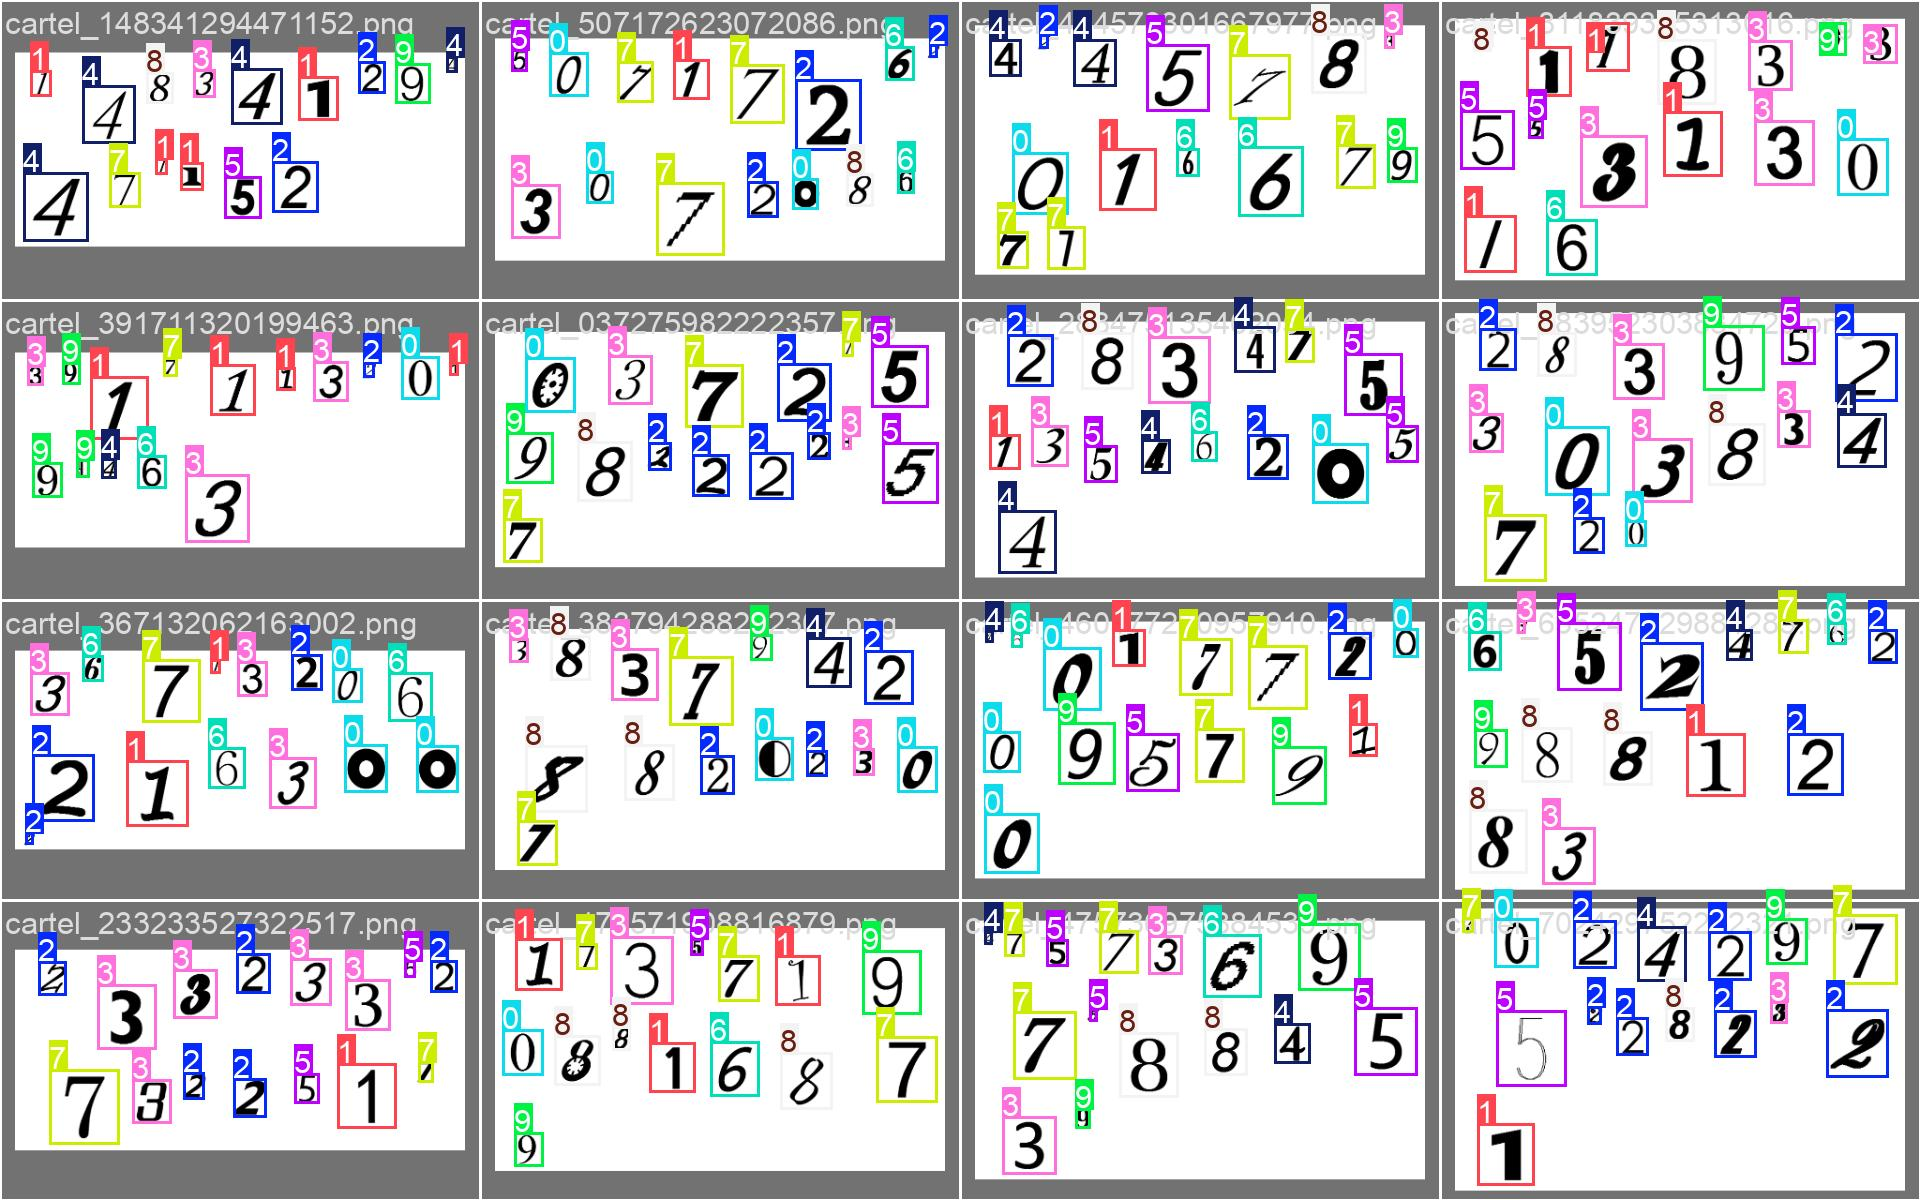


> Grafico  val_batch2_pred.jpg :


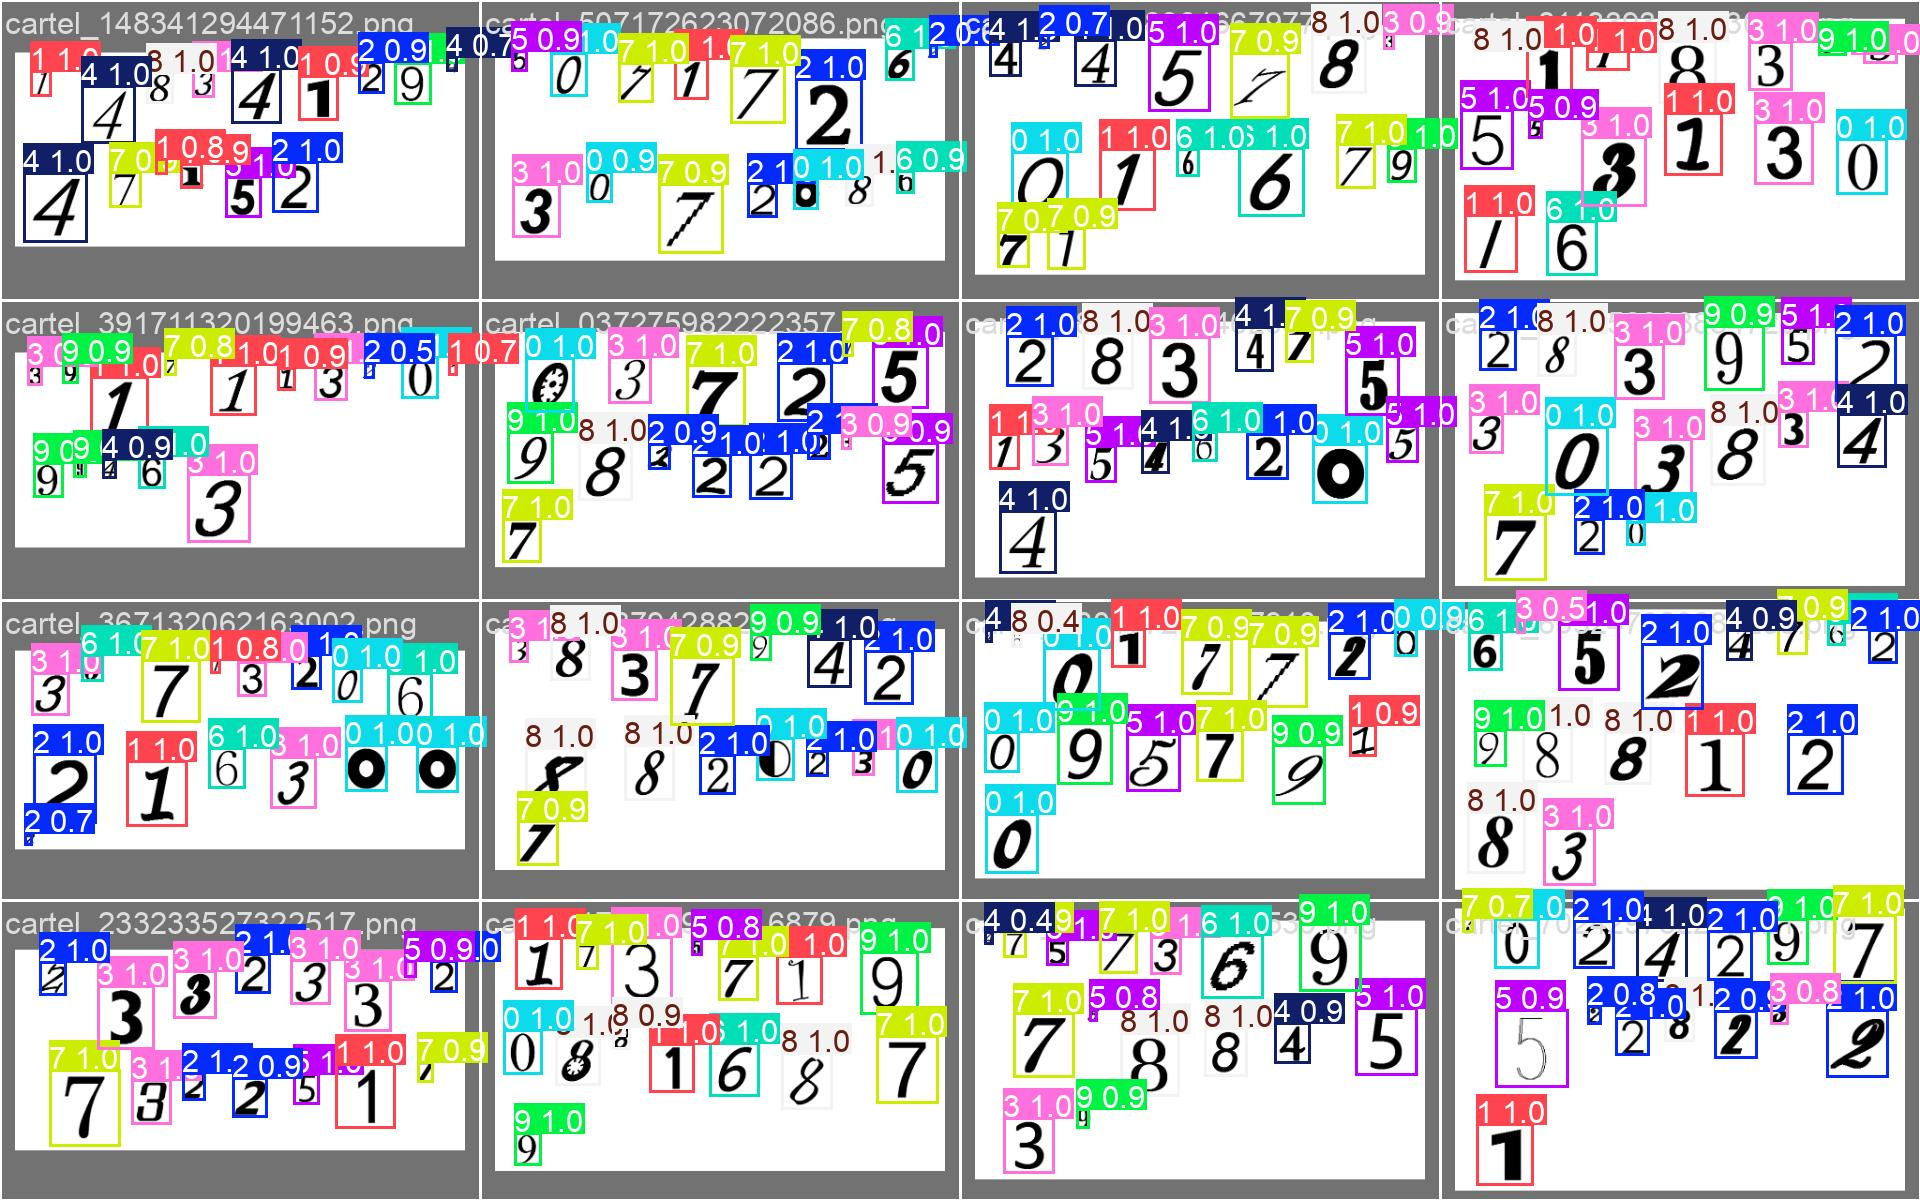

In [8]:
#@title Validar el modelo entrenado usando librería

metrics = model.val(data=path_to_data_yaml,
                    plots=True)

print("\n> Métricas: ")
display( metrics.to_df() )

print("\n> Matriz de confusión: ")
display( metrics.confusion_matrix.to_df() )

print("\n> mAP 50-95: ", metrics.box.map*100.0 )

# muestra gráficos si están disponibles
grDir = str(metrics.save_dir)
if os.path.isdir(grDir):
  grFiles = list(os.listdir(grDir))
  grFiles.sort()
  for grFN in grFiles:
    _, ext = os.path.splitext(grFN)
    if ext.lower() in [".jpg", ".png"]:
      print("\n> Grafico ", grFN, ":")
      display( Image(filename=grDir+"/"+grFN) )

print("")


 > cartel_283475135462054.png :


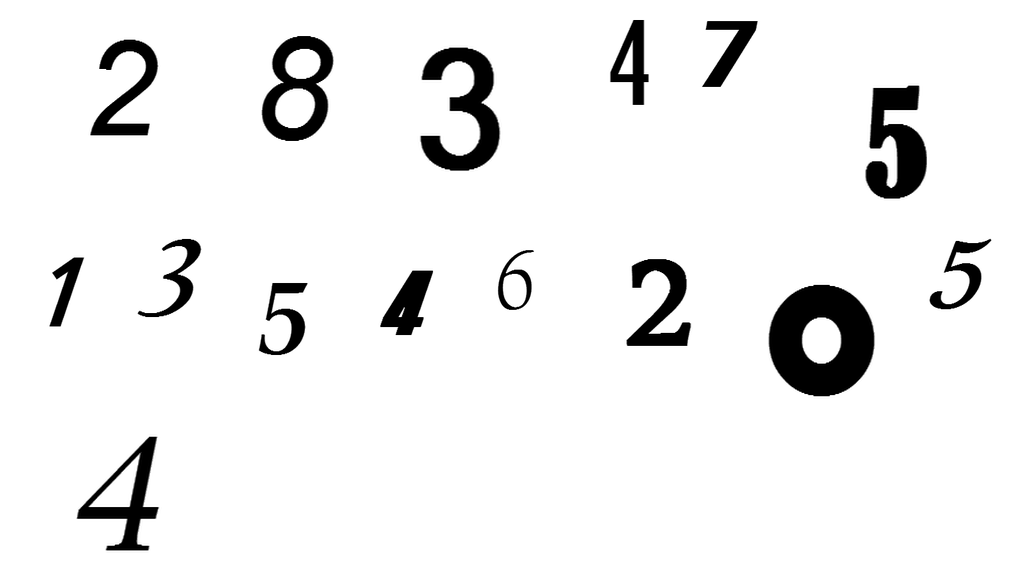



image 1/1 /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles/validation/images/cartel_283475135462054.png: 288x480 2 2s, 1 0, 1 8, 1 6, 3 4s, 2 3s, 1 1, 1 7, 3 5s, 80.0ms
Speed: 2.1ms preprocess, 80.0ms inference, 2.5ms postprocess per image at shape (1, 3, 288, 480)


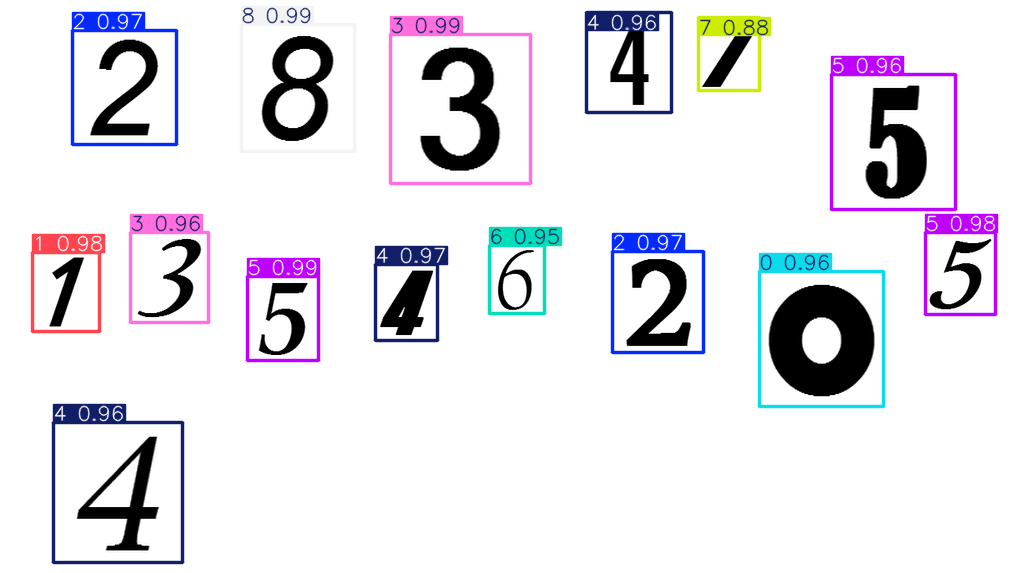

	 {'name': '8', 'class': 2, 'confidence': 0.99194, 'box': {'x1': 241.25658, 'y1': 24.63848, 'x2': 354.51315, 'y2': 151.7951}}
	 {'name': '5', 'class': 9, 'confidence': 0.98997, 'box': {'x1': 247.81517, 'y1': 276.92853, 'x2': 318.61813, 'y2': 360.10489}}
	 {'name': '3', 'class': 5, 'confidence': 0.98988, 'box': {'x1': 390.77039, 'y1': 34.53919, 'x2': 530.15674, 'y2': 183.6595}}
	 {'name': '1', 'class': 6, 'confidence': 0.97884, 'box': {'x1': 32.48942, 'y1': 252.33089, 'x2': 99.64423, 'y2': 331.20779}}
	 {'name': '5', 'class': 9, 'confidence': 0.97827, 'box': {'x1': 925.68964, 'y1': 232.69989, 'x2': 995.80945, 'y2': 314.22144}}
	 {'name': '2', 'class': 0, 'confidence': 0.97216, 'box': {'x1': 72.46181, 'y1': 30.13462, 'x2': 176.7491, 'y2': 144.69698}}
	 {'name': '2', 'class': 0, 'confidence': 0.97137, 'box': {'x1': 612.08997, 'y1': 251.08098, 'x2': 703.54022, 'y2': 352.83295}}
	 {'name': '4', 'class': 4, 'confidence': 0.97002, 'box': {'x1': 375.01605, 'y1': 264.92297, 'x2': 437.02933, 'y2

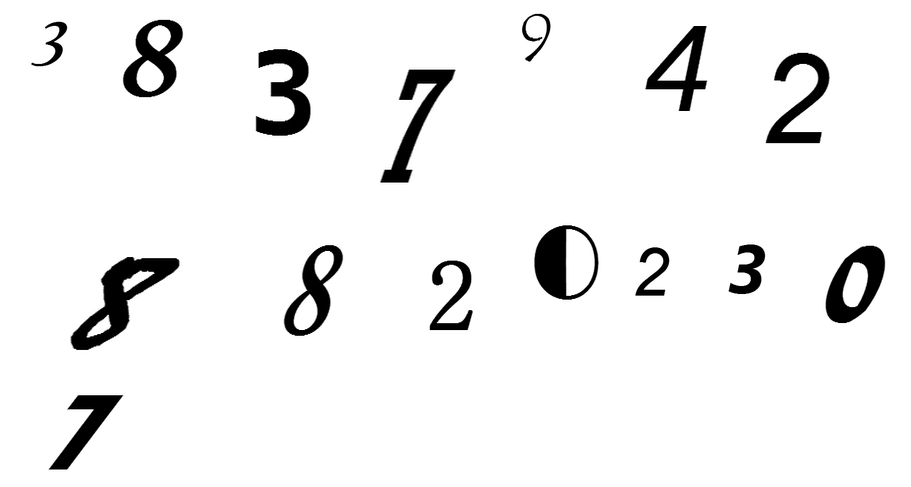



image 1/1 /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles/validation/images/cartel_383794288202307.png: 288x480 3 2s, 2 0s, 3 8s, 1 4, 3 3s, 2 7s, 1 9, 14.9ms
Speed: 1.7ms preprocess, 14.9ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 480)


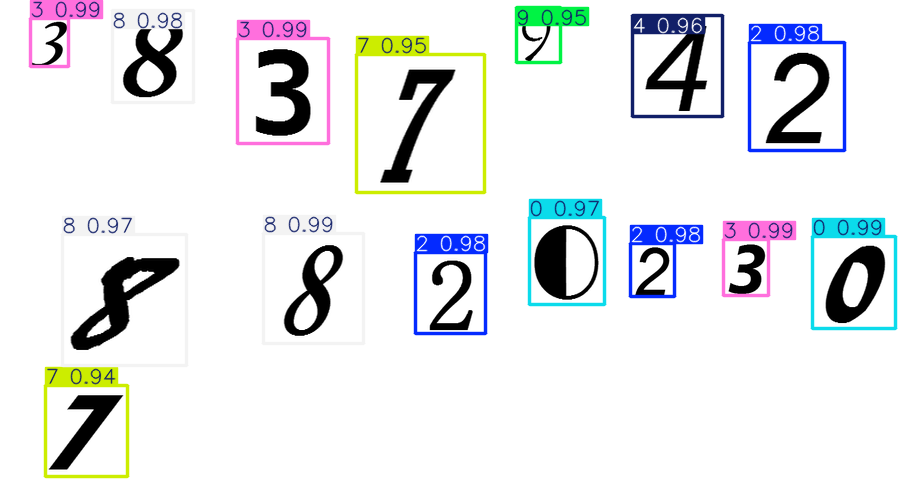

	 {'name': '3', 'class': 5, 'confidence': 0.99499, 'box': {'x1': 237.17314, 'y1': 38.77816, 'x2': 328.83392, 'y2': 143.07855}}
	 {'name': '3', 'class': 5, 'confidence': 0.99212, 'box': {'x1': 723.5705, 'y1': 239.85068, 'x2': 768.51947, 'y2': 295.11716}}
	 {'name': '8', 'class': 2, 'confidence': 0.98745, 'box': {'x1': 263.52783, 'y1': 233.26833, 'x2': 363.09213, 'y2': 343.73254}}
	 {'name': '0', 'class': 1, 'confidence': 0.98594, 'box': {'x1': 812.97388, 'y1': 236.20387, 'x2': 895.45123, 'y2': 328.75668}}
	 {'name': '3', 'class': 5, 'confidence': 0.9858, 'box': {'x1': 30.17552, 'y1': 18.51442, 'x2': 68.21077, 'y2': 66.4633}}
	 {'name': '2', 'class': 0, 'confidence': 0.98369, 'box': {'x1': 630.84314, 'y1': 243.2365, 'x2': 674.16254, 'y2': 296.34366}}
	 {'name': '2', 'class': 0, 'confidence': 0.98334, 'box': {'x1': 749.44775, 'y1': 42.52465, 'x2': 844.30444, 'y2': 150.29471}}
	 {'name': '8', 'class': 2, 'confidence': 0.97616, 'box': {'x1': 112.78656, 'y1': 10.04883, 'x2': 193.43405, 'y2':

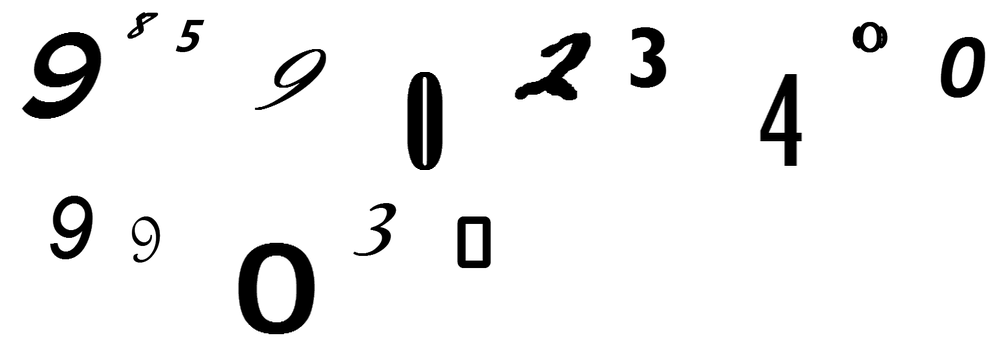



image 1/1 /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles/validation/images/cartel_985902340099030.png: 192x480 1 2, 5 0s, 1 4, 2 3s, 5 9s, 1 5, 85.9ms
Speed: 2.8ms preprocess, 85.9ms inference, 2.0ms postprocess per image at shape (1, 3, 192, 480)


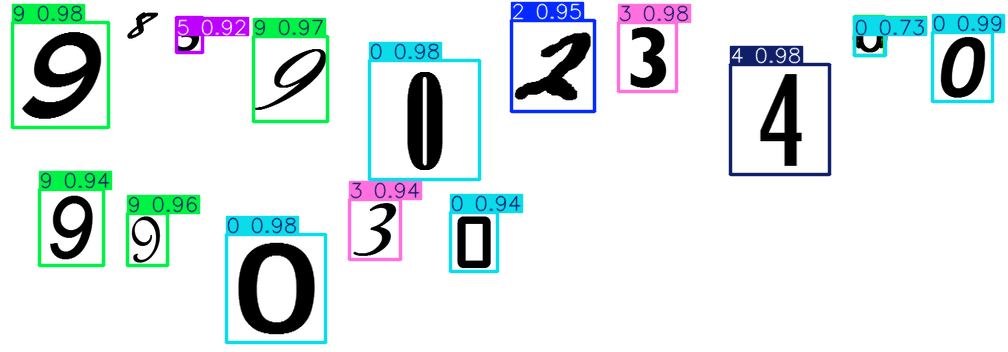

	 {'name': '0', 'class': 1, 'confidence': 0.98525, 'box': {'x1': 932.89984, 'y1': 32.228, 'x2': 992.6637, 'y2': 101.97754}}
	 {'name': '4', 'class': 4, 'confidence': 0.97939, 'box': {'x1': 730.88098, 'y1': 64.06415, 'x2': 829.06317, 'y2': 174.84029}}
	 {'name': '3', 'class': 5, 'confidence': 0.97891, 'box': {'x1': 618.56378, 'y1': 22.03974, 'x2': 676.65521, 'y2': 91.3929}}
	 {'name': '0', 'class': 1, 'confidence': 0.97786, 'box': {'x1': 226.9024, 'y1': 234.12109, 'x2': 325.67224, 'y2': 342.19791}}
	 {'name': '0', 'class': 1, 'confidence': 0.97681, 'box': {'x1': 369.98105, 'y1': 60.32438, 'x2': 479.2196, 'y2': 179.98404}}
	 {'name': '9', 'class': 8, 'confidence': 0.97597, 'box': {'x1': 12.84513, 'y1': 22.5399, 'x2': 108.15754, 'y2': 127.39574}}
	 {'name': '9', 'class': 8, 'confidence': 0.9742, 'box': {'x1': 253.83784, 'y1': 36.07146, 'x2': 327.65833, 'y2': 121.45769}}
	 {'name': '9', 'class': 8, 'confidence': 0.95768, 'box': {'x1': 127.03498, 'y1': 213.84367, 'x2': 167.14845, 'y2': 265.

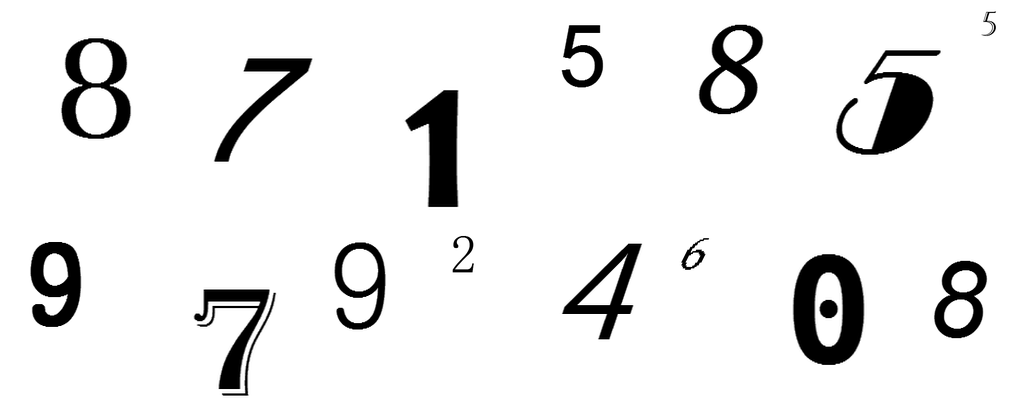



image 1/1 /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles/validation/images/cartel_871585597924608.png: 224x480 1 2, 1 0, 3 8s, 1 6, 1 4, 1 1, 2 7s, 2 9s, 3 5s, 76.4ms
Speed: 1.6ms preprocess, 76.4ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 480)


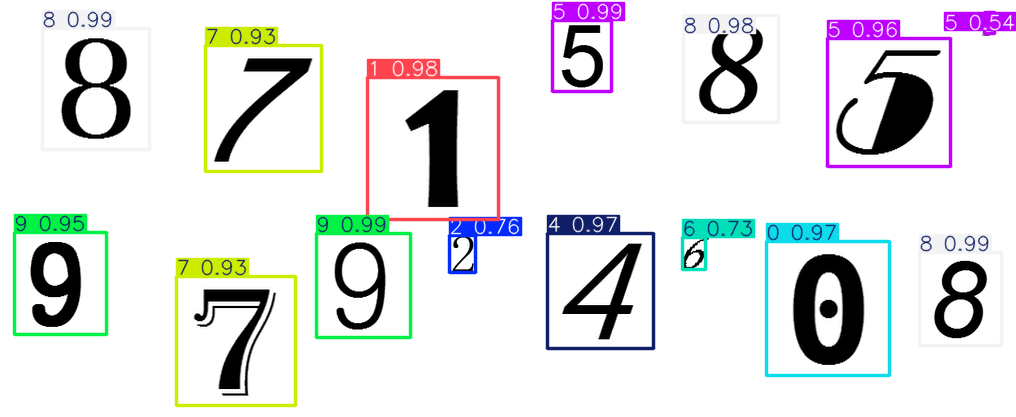

	 {'name': '8', 'class': 2, 'confidence': 0.99225, 'box': {'x1': 919.51495, 'y1': 252.41553, 'x2': 1001.58368, 'y2': 345.25299}}
	 {'name': '9', 'class': 8, 'confidence': 0.99162, 'box': {'x1': 316.18069, 'y1': 233.69247, 'x2': 410.48618, 'y2': 337.32593}}
	 {'name': '5', 'class': 9, 'confidence': 0.99073, 'box': {'x1': 552.98773, 'y1': 20.0409, 'x2': 611.61346, 'y2': 91.10485}}
	 {'name': '8', 'class': 2, 'confidence': 0.98989, 'box': {'x1': 42.07685, 'y1': 28.35087, 'x2': 149.96722, 'y2': 149.54584}}
	 {'name': '1', 'class': 6, 'confidence': 0.98261, 'box': {'x1': 367.11465, 'y1': 77.50357, 'x2': 498.06894, 'y2': 219.23703}}
	 {'name': '8', 'class': 2, 'confidence': 0.97649, 'box': {'x1': 683.8009, 'y1': 15.13278, 'x2': 778.98145, 'y2': 122.84551}}
	 {'name': '4', 'class': 4, 'confidence': 0.96662, 'box': {'x1': 547.77496, 'y1': 233.76935, 'x2': 653.64172, 'y2': 348.0351}}
	 {'name': '0', 'class': 1, 'confidence': 0.96551, 'box': {'x1': 766.30408, 'y1': 241.60164, 'x2': 889.3963, 'y2

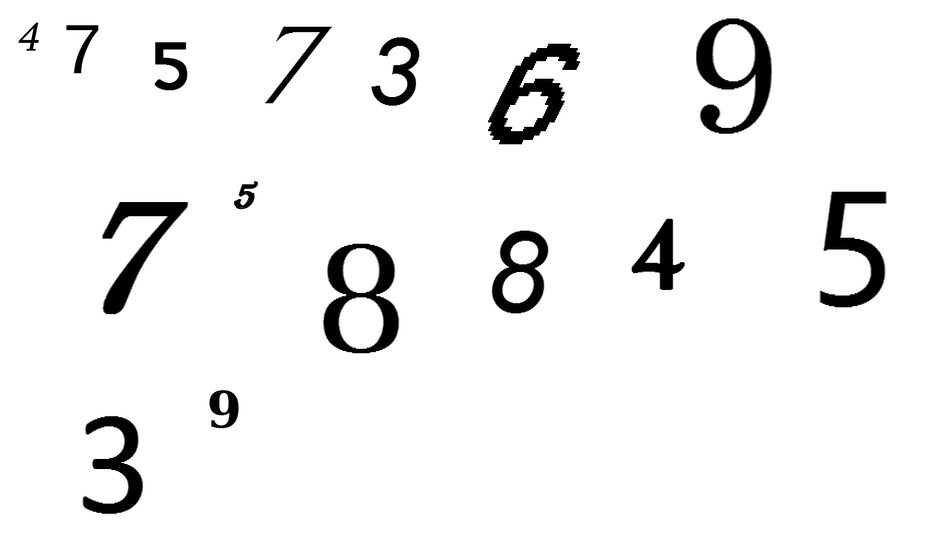



image 1/1 /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles/validation/images/cartel_475736975884539.png: 288x480 2 8s, 1 6, 2 4s, 2 3s, 3 7s, 2 9s, 3 5s, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 480)


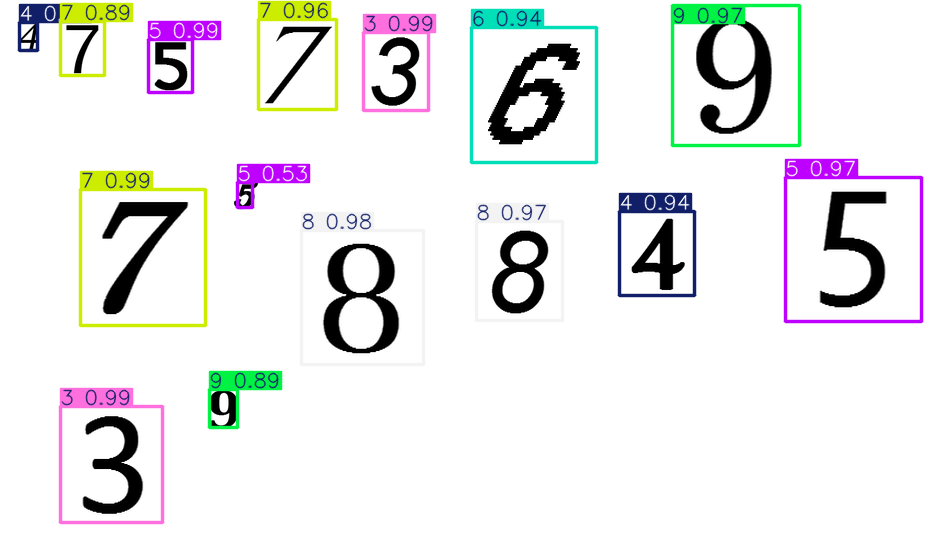

	 {'name': '3', 'class': 5, 'confidence': 0.99356, 'box': {'x1': 60.10334, 'y1': 406.91721, 'x2': 162.87625, 'y2': 522.91559}}
	 {'name': '7', 'class': 7, 'confidence': 0.9924, 'box': {'x1': 80.9099, 'y1': 189.72157, 'x2': 205.91969, 'y2': 325.20026}}
	 {'name': '3', 'class': 5, 'confidence': 0.98993, 'box': {'x1': 363.2822, 'y1': 32.35189, 'x2': 428.37183, 'y2': 110.51552}}
	 {'name': '5', 'class': 9, 'confidence': 0.98985, 'box': {'x1': 148.84607, 'y1': 39.84916, 'x2': 192.43742, 'y2': 92.26595}}
	 {'name': '8', 'class': 2, 'confidence': 0.98388, 'box': {'x1': 301.95288, 'y1': 230.82393, 'x2': 423.80386, 'y2': 364.43765}}
	 {'name': '9', 'class': 8, 'confidence': 0.97449, 'box': {'x1': 672.62305, 'y1': 5.7177, 'x2': 799.80084, 'y2': 145.89397}}
	 {'name': '8', 'class': 2, 'confidence': 0.97315, 'box': {'x1': 476.42044, 'y1': 221.85423, 'x2': 562.74792, 'y2': 320.64767}}
	 {'name': '5', 'class': 9, 'confidence': 0.96925, 'box': {'x1': 785.55951, 'y1': 177.49182, 'x2': 921.5202, 'y2': 

In [9]:
#@title Ejecutar Modelo con ejemplos

#@title Seleccionar y cargar las imágenes para usar en la prueba
fuente_imgenes = "Validación" #@param ["Entrenamiento", "Validación"]
cant_imagenes = 5 #@param {type:"integer"}

if cant_imagenes>0:

  # deterimina fuente
  if fuente_imgenes == "Entrenamiento":
    dir_imagenes = path+subdirTrainImages
  else:
    dir_imagenes = path+subdirValImages

  # toma imágenes al azar
  all_images_array = [ fn for fn in os.listdir( dir_imagenes)  ]
  np.random.shuffle(all_images_array)
  sel_images_array, _ = np.split(np.array(all_images_array), [cant_imagenes])

  # crea carpeta temporal
  dirTemp = tempfile.mkdtemp()

  # procea y muestra resultados
  for fn in sel_images_array:
    fn_path = dir_imagenes+"/"+fn
    print("\n >", fn, ":")
    display( Image(filename=fn_path) )
    print("")
    # Run inference on the source
    results = model(fn_path)

    # Process results list
    for result in results:
        ##boxes = result.boxes  # Boxes object for bounding box outputs
        ##masks = result.masks  # Masks object for segmentation masks outputs
        ##keypoints = result.keypoints  # Keypoints object for pose outputs
        ##probs = result.probs  # Probs object for classification outputs
        ##obb = result.obb  # Oriented boxes object for OBB outputs
        # muestra resultados
        resultFN = dirTemp + "/res_" + fn
        result.save(filename=resultFN)  # save to disk
        display( Image(filename=resultFN) )
        for res in result.summary():
          print("\t", res)


# Exportación del Modelo:

In [10]:
#@title Grabar el modelo entrenado formato PyTorch

path_modeloYOLO = '/content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Modelo' #@param {type:"string"}

# graba modelo
if not os.path.isdir(path_modeloYOLO):
  os.makedirs(path_modeloYOLO)

save_model_name = path_modeloYOLO + "/model.pt"
model.save(save_model_name)

print("\n-- Modelo grabado en ", save_model_name)



-- Modelo grabado en  /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Modelo/model.pt


In [11]:
#@title Exportar el modelo entrenado

path_modelo = '/content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Modelo' #@param {type:"string"}

tipo_modelo_exportar = "TF SavedModel" #@param [ "onnx", "TF SavedModel", "TF GraphDef", "TF Lite", "TF Edge TPU", "TF.js" ]

# ver lista completa de formatos de exportación
# en https://docs.ultralytics.com/es/modes/export/#export-formats
if tipo_modelo_exportar == "onnx":
  export_format = "onnx"
elif tipo_modelo_exportar ==  "PyTorch":
  export_format = None
elif tipo_modelo_exportar ==  "TF Edge TPU":
  export_format = "edgetpu"
elif tipo_modelo_exportar ==  "TF SavedModel":
  export_format = "saved_model"
elif tipo_modelo_exportar ==  "TF GraphDef":
  export_format = "pb"
elif tipo_modelo_exportar ==  "TF Lite":
  export_format = "tflite"
elif tipo_modelo_exportar == "TF.js":
  export_format = "tfjs"
else:
  export_format = None
  print("ERROR: formato de exportación ", tipo_modelo_exportar, "no soportado!")

# Export the model to format
export_model_name = model.export(format=export_format)
print("\n-- Modelo exportado en ", export_model_name)

# copia modelo al drive
if path_modelo != "":
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    if os.path.isdir(export_model_name):
        path_modeloDir = path_modelo+"/"+export_format
        shutil.copytree(export_model_name, path_modeloDir)
        print("\n-- Modelo ", export_model_name, "copiado a ", path_modeloDir)
    elif os.path.isfile(export_model_name):
        shutil.copy2(export_model_name, path_modelo)
        print("\n-- Modelo ", export_model_name, "copiado a ", path_modelo)
    else:
      print("ERROR: no se encontró el modelo exportado!")


Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 480, 480) BCHW and output shape(s) (1, 14, 4725) (5.2 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'ai-edge-litert>=1.2.0', 'onnx>=1.12.0', 'onnx2tf>=1.26.3', 'onnxslim>=0.1.67', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 14.8s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


TensorFlow SavedModel: starting export with tensorflow 2.19.0...
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100% ━━━━━━━━━━━━ 1/1 53.7files/s 0.0s

ONNX: starting export wi

In [12]:
#@title Exportar el modelo entrenado (otro formato)

tipo_modelo_exportar = "onnx" #@param [ "onnx", "TF SavedModel", "TF GraphDef", "TF Lite", "TF Edge TPU", "TF.js" ]

# ver lista completa de formatos de exportación
# en https://docs.ultralytics.com/es/modes/export/#export-formats
if tipo_modelo_exportar == "onnx":
  export_format = "onnx"
elif tipo_modelo_exportar ==  "PyTorch":
  export_format = None
elif tipo_modelo_exportar ==  "TF Edge TPU":
  export_format = "edgetpu"
elif tipo_modelo_exportar ==  "TF SavedModel":
  export_format = "saved_model"
elif tipo_modelo_exportar ==  "TF GraphDef":
  export_format = "pb"
elif tipo_modelo_exportar ==  "TF Lite":
  export_format = "tflite"
elif tipo_modelo_exportar == "TF.js":
  export_format = "tfjs"
else:
  export_format = None
  print("ERROR: formato de exportación ", tipo_modelo_exportar, "no soportado!")

# Export the model to format
export_model_name = model.export(format=export_format)
print("\n-- Modelo exportado en ", export_model_name)

# copia modelo al drive
if path_modelo != "":
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    if os.path.isdir(export_model_name):
        path_modeloDir = path_modelo+"/"+export_format
        shutil.copytree(export_model_name, path_modeloDir)
        print("\n-- Modelo ", export_model_name, "copiado a ", path_modeloDir)
    elif os.path.isfile(export_model_name):
        shutil.copy2(export_model_name, path_modelo)
        print("\n-- Modelo ", export_model_name, "copiado a ", path_modelo)
    else:
      print("ERROR: no se encontró el modelo exportado!")


Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 480, 480) BCHW and output shape(s) (1, 14, 4725) (5.2 MB)

ONNX: starting export with onnx 1.19.1rc1 opset 22...
ONNX: slimming with onnxslim 0.1.70...
ONNX: export success ✅ 1.1s, saved as '/content/runs/detect/train/weights/best.onnx' (10.0 MB)

Export complete (1.3s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=/content/runs/detect/train/weights/best.onnx imgsz=480  
Validate:        yolo val task=detect model=/content/runs/detect/train/weights/best.onnx imgsz=480 data=/content/YOLOconfig.yaml  
Visualize:       https://netron.app

-- Modelo exportado en  /content/runs/detect/train/weights/best.onnx

-- Modelo  /content/runs/detect/train/weights/best.onnx copiado a  /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Modelo


In [13]:
#@title Exportar el modelo entrenado (otro formato)

tipo_modelo_exportar = "TF.js" #@param [ "onnx", "TF SavedModel", "TF GraphDef", "TF Lite", "TF Edge TPU", "TF.js" ]

# ver lista completa de formatos de exportación
# en https://docs.ultralytics.com/es/modes/export/#export-formats
if tipo_modelo_exportar == "onnx":
  export_format = "onnx"
elif tipo_modelo_exportar ==  "PyTorch":
  export_format = None
elif tipo_modelo_exportar ==  "TF Edge TPU":
  export_format = "edgetpu"
elif tipo_modelo_exportar ==  "TF SavedModel":
  export_format = "saved_model"
elif tipo_modelo_exportar ==  "TF GraphDef":
  export_format = "pb"
elif tipo_modelo_exportar ==  "TF Lite":
  export_format = "tflite"
elif tipo_modelo_exportar == "TF.js":
  export_format = "tfjs"
else:
  export_format = None
  print("ERROR: formato de exportación ", tipo_modelo_exportar, "no soportado!")

# Export the model to format
export_model_name = model.export(format=export_format)
print("\n-- Modelo exportado en ", export_model_name)

# copia modelo al drive
if path_modelo != "":
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    if os.path.isdir(export_model_name):
        path_modeloDir = path_modelo+"/"+export_format
        shutil.copytree(export_model_name, path_modeloDir)
        print("\n-- Modelo ", export_model_name, "copiado a ", path_modeloDir)
    elif os.path.isfile(export_model_name):
        shutil.copy2(export_model_name, path_modelo)
        print("\n-- Modelo ", export_model_name, "copiado a ", path_modelo)
    else:
      print("ERROR: no se encontró el modelo exportado!")


Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 480, 480) BCHW and output shape(s) (1, 14, 4725) (5.2 MB)

TensorFlow SavedModel: starting export with tensorflow 2.19.0...

ONNX: starting export with onnx 1.19.1rc1 opset 22...
ONNX: slimming with onnxslim 0.1.70...
ONNX: export success ✅ 1.1s, saved as '/content/runs/detect/train/weights/best.onnx' (10.1 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.28.2...
Saved artifact at '/content/runs/detect/train/weights/best_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 480, 480, 3), dtype=tf.float32, name='images')
Output Type:
  TensorSpec(shape=(1, 14, 4725), dtype=tf.float32, name=None)
Captures:
  133444769565008: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  133444769565200: TensorSpec(shape=(3, 3,


TensorFlow.js: starting export with tensorflowjs 4.22.0...

TensorFlow.js: output node names: Identity:0
TensorFlow.js: running 'tensorflowjs_converter --input_format=tf_frozen_model  --output_node_names=Identity:0 "/content/runs/detect/train/weights/best.pb" "/content/runs/detect/train/weights/best_web_model"'
TensorFlow.js: export success ✅ 7.9s, saved as '/content/runs/detect/train/weights/best_web_model' (10.3 MB)

Export complete (26.9s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=/content/runs/detect/train/weights/best_web_model imgsz=480  
Validate:        yolo val task=detect model=/content/runs/detect/train/weights/best_web_model imgsz=480 data=/content/YOLOconfig.yaml  
Visualize:       https://netron.app

-- Modelo exportado en  /content/runs/detect/train/weights/best_web_model

-- Modelo  /content/runs/detect/train/weights/best_web_model copiado a  /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Modelo/tfjs
